Imports

In [1]:
%matplotlib inline
# Basic
from collections import OrderedDict
from datetime import datetime, timedelta
from pathlib import Path
import re
from playsound import playsound
# Numbers
import pandas as pd
import numpy as np
# Graphic
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib import patheffects as pe
import seaborn as sns
# Models
import pmdarima as pm
from arch.univariate import ZeroMean, GARCH, Normal # 3 components of GARCH model
import tensorflow as tf
from tensorflow import keras
# Statistics
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS, GLS

In [117]:
from __future__ import division
from matplotlib.ticker import FuncFormatter

Data retrival

In [2]:
# LOAD NAMES
dmkt = "C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/cleaned/univariate/market_indices/market_names.csv"
mkt_names = pd.read_csv(dmkt).values.tolist()
mkt_names = [item for sublist in mkt_names for item in sublist]
# clean string data
pattern = [('.','_'),('Index','intra'), ('IMOEX','moex'), ('TFTSEMIB','ftsemib')]
names = []
for name in mkt_names:
    for rep, repl in pattern:
        name = str(name).replace(rep, repl)
    names.append(str(name).lower())
mkt_names = names
del names
# remove index name of file that doesn't exist
mkt_names = [name for name in mkt_names if 'indu' not in name]

# LOAD DATA
dd = "C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/multi_series_data/intraday/clean/longest/"
dirs = []
data = OrderedDict()
for i in range(len(mkt_names)):
    # concat strings to get directories
    nm = mkt_names[i]
    directory = dd+nm+"_clean.xlsx"
    # store
    dirs.append(directory)
    data[nm] = pd.read_excel(directory)
    del directory, nm

In [3]:
mkt_names

['kospi_intra',
 'jci_intra',
 'spx_intra',
 'shsz300_intra',
 'sptsx_intra',
 'nky_intra',
 'saseidx_intra',
 'as51_intra',
 'jalsh_intra',
 'xu100_intra',
 'ukx_intra',
 'n100_intra',
 'hsi_intra',
 'nifty_intra',
 'moex_intra',
 'ftsemib_intra',
 'cac_intra',
 'dax_intra',
 'mexbol_intra',
 'ibex_intra',
 'merval_intra']

Constant specifications

In [4]:
# SCALING FACTOR
SCALE = 100
DESCALE = 1/SCALE

# AE datastructures
LAGS = 128
TIME_STEPS = 128

# Date parameters
E1 = pd.to_datetime("2020-01-13")
E2 = pd.to_datetime("2020-01-24")
E3 = pd.to_datetime("2020-02-24")
E4 = pd.to_datetime("2020-03-09")

CUT1 = pd.to_datetime("2019-04-29")
CUT2 = pd.to_datetime("2020-06-01")

EXCLUSION = pd.to_datetime("2010-01-01")

# Plot parameters
SCATTER = 25
ALPHA = 0.8
LINEWIDTH = 1.5

TITLE_FONT = {
        'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30
        }

AXIS_FONT = {
        'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15
        }

DATE_FORM  = DateFormatter('%Y-%m-%d')

Notebook Settings

In [5]:
def ps():
    playsound('C:/Windows/Media/notify.wav')
ps()

In [6]:
# set data splitting parameters
EVENT = E1

# Toggle Settings
store_stats_results = True
save_ae_results = True
show_plots = True
save_figs = True

# Returns
var_mode = 'log_prices' # alternative = 'log_returns'

# Bounded Scaling
rescale = False

# Cutting out of sample
exclude = True

# Plot settings
plt.style.use('seaborn')
plt.rc('font', **AXIS_FONT)
plt.rc('xtick', labelsize=15)  
plt.rc('ytick', labelsize=15)

Initial Data Wrangling

In [7]:
# select data
MKT = 'spx_intra' # from mkt_names
dataset = data[MKT].copy(deep=True)
# quick formatting wrangle
dataset = dataset.rename(columns=dict(zip(dataset.columns, [str(col).lower() for col in dataset.columns]))).set_index('date').sort_index()
# take log of prices
dataset = np.log(dataset)
dataset.name = MKT

In [8]:
# split dataset
# Y = dataset.val
# X = pd.concat([pd.to_datetime(dataset.date), pd.Series(range(len(Y)))], axis=1).rename({'date':'date',0:'index'},axis=1)
# X_in = X.index[X.date < EVENT]
# X_out = X.index[X.date >= EVENT]
train = dataset[(dataset.index < EVENT)] # & (dataset['date'] > pd.to_datetime("2016-01-01")) 
test = dataset[(dataset.index >= EVENT)]
# Inspect
print(
    'TABULAR DATA:', '\n',
    'train.shape: ', train.shape, '\n',
    'test.shape: ', test.shape
    )

# retain date seqs
dtrain, dtest = pd.to_datetime(train.index), pd.to_datetime(test.index)
# format structures (and dtypes) for arima
# Y, train, test = Y.values, train.val.values, test.val.values
# Inspect and compare
print(
    'DATA VECTORS:', '\n',
    'train.shape: ', train.shape, '\n',
    'test.shape: ', test.shape
    )

TABULAR DATA: 
 train.shape:  (41935, 4) 
 test.shape:  (7307, 4)
DATA VECTORS: 
 train.shape:  (41935, 4) 
 test.shape:  (7307, 4)


In [9]:
prices = dataset.open

Storage Directories for Results

In [10]:
d_model_results = 'C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/results/fanomal/intra/'

d_arima = d_model_results+'arima_results/'+MKT+'/'
d_arima_plots = d_arima+'plots/'

d_garch = d_model_results+'garch_results/'+MKT+'/'
d_garch_plots = d_garch+'plots/'

d_ae = d_model_results+'ae_results/'+MKT+'/'
d_ae_plots = d_ae+'plots/'
d_ae_models = d_ae+'models/'
d_ae_results = d_ae+'results/'

d_ae_predictions = 'predictions/'
d_ae_error = 'error/'

# Ensure appropriate nested directories exit
Path(d_arima).mkdir(parents=True, exist_ok=True)
Path(d_arima_plots).mkdir(parents=True, exist_ok=True)

Path(d_garch).mkdir(parents=True, exist_ok=True)
Path(d_garch_plots).mkdir(parents=True, exist_ok=True)

Path(d_ae).mkdir(parents=True, exist_ok=True)
Path(d_ae_plots).mkdir(parents=True, exist_ok=True)
Path(d_ae_results).mkdir(parents=True, exist_ok=True)

.______________________________.

ARIMA Modelling

In [11]:
ORDER = (1,1,1)

arimas = {}
# temp_lst = []
for col in train.columns:
    Y = dataset[col]
    # construct arima model of order ORDER, keeping data out of sample
    arima = pm.ARIMA(order=ORDER, out_of_sample_size=int(test.shape[0]))
    fit = arima.fit(Y)
    # predict in sample
    pred_in = fit.predict_in_sample(start=1, end=Y.shape[0], dynamic=False, return_conf_int=True)
    # extract upper & lower confidence intervals of predictions
    lw = pd.DataFrame({'date':dataset.index, 'lower':[pred_in[1][i][0] for i in range(pred_in[1].shape[0])]}).set_index('date')
    up = pd.DataFrame({'date':dataset.index, 'upper':[pred_in[1][i][1] for i in range(pred_in[1].shape[0])]}).set_index('date')
    resid = fit.resid()
    arimas[col] = {'model':arima, 'fit':fit, 'pred_in':pred_in[0], 'lw':lw, 'up':up, 'resid':resid}
    del arima, fit, pred_in, lw, up, resid

# play sound to notify cell is finished
ps()

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


In [12]:
# Build pd.DataFrames to make plotting easier
predicted = pd.DataFrame({
    'date':dataset.index,
    'open':arimas['open']['pred_in'],
    'high':arimas['high']['pred_in'],
    'low':arimas['low']['pred_in'],
    'close':arimas['close']['pred_in'],}).set_index('date').sort_index()
arima_resids = pd.DataFrame({
    'date':dataset.index,
    'open':arimas['open']['resid'],
    'high':arimas['high']['resid'],
    'low':arimas['low']['resid'],
    'close':arimas['close']['resid']}).set_index('date').sort_index()
train_test = {'train':train, 'test':test}

In [13]:
print('start: ', predicted.head(1).index, '\nend:',predicted.tail(1).index)

start:  DatetimeIndex(['2008-01-02 09:30:00'], dtype='datetime64[ns]', name='date', freq=None) 
end: DatetimeIndex(['2022-02-07 16:00:00'], dtype='datetime64[ns]', name='date', freq=None)


ARIMA Plots

C:\Users\Keegan\AppData\Local\Temp\ipykernel_4100\3459526148.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


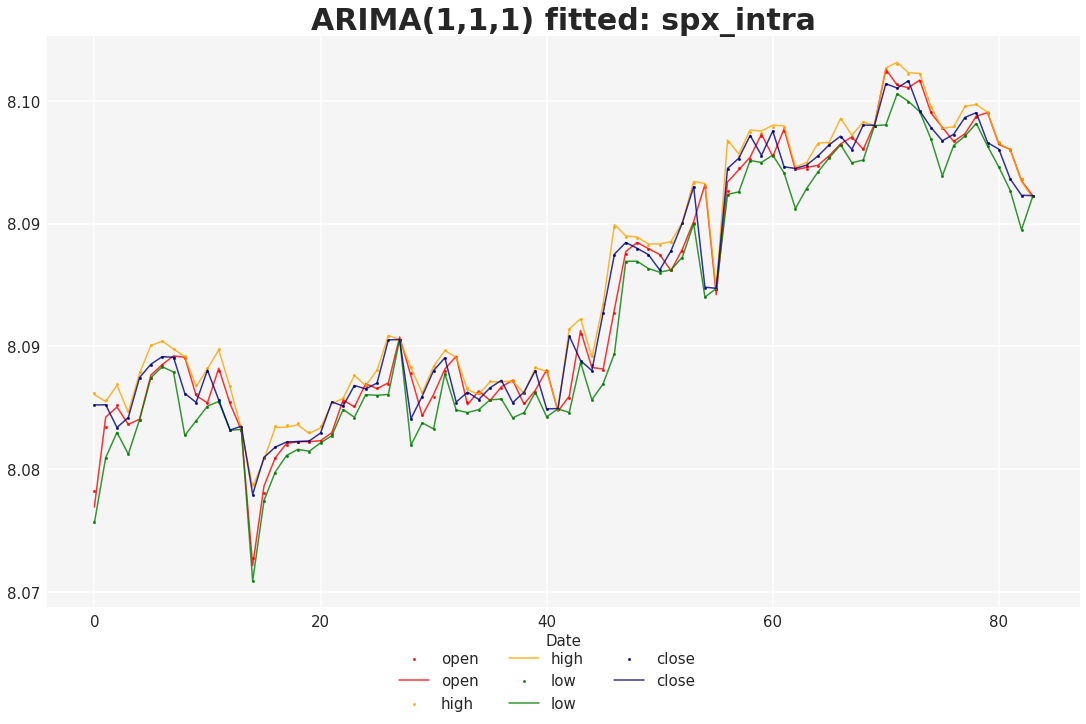

In [14]:
S1 = (E1-timedelta(10), E1)
# S2 = slice(dataset.index>E1)

# Plot actual test vs. forecasts:
colours = ['red', 'orange', 'green', 'navy']
fig, ax = plt.subplots()
for i in range(dataset.shape[1]):
    ax.scatter(
        range(len(dataset.index[(dataset.index>S1[0])&(dataset.index<=S1[1])])),
        dataset[dataset.columns[i]][(dataset.index>S1[0])&(dataset.index<=S1[1])].values,
        marker = '.',
        s = SCATTER,
        alpha = 1,
        color = colours[i],
        label = dataset.columns[i] #"SP500"
        )
    ax.plot(
        predicted[dataset.columns[i]][(predicted.index>S1[0])&(predicted.index<=S1[1])].values, #['close'][(predicted.index>S1[0])&(predicted.index<=S1[1])].values,
        alpha = ALPHA,
        linewidth = LINEWIDTH,
        color = colours[i],
        label = predicted.columns[i]
        )

ax.set_facecolor('whitesmoke')
ax.fmt_xdata = DATE_FORM
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel('Date',fontdict=AXIS_FONT)
fig.legend(loc=8, bbox_to_anchor=(0.5, -0.03), ncol=3, prop={'size':15})
# fig.autofmt_xdate()
fig.set_size_inches(18.5, 10.5)
plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
plt.title('ARIMA(1,1,1) fitted: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
if show_plots:
    fig.show()
else:
    print("Not showing plot.")

if show_plots & save_figs:
    fig.savefig((d_arima_plots+MKT+'_ARIMA'+str(ORDER)+'_full-fit_CLOSE_UP.png'), dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

C:\Users\Keegan\AppData\Local\Temp\ipykernel_4100\3018719464.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


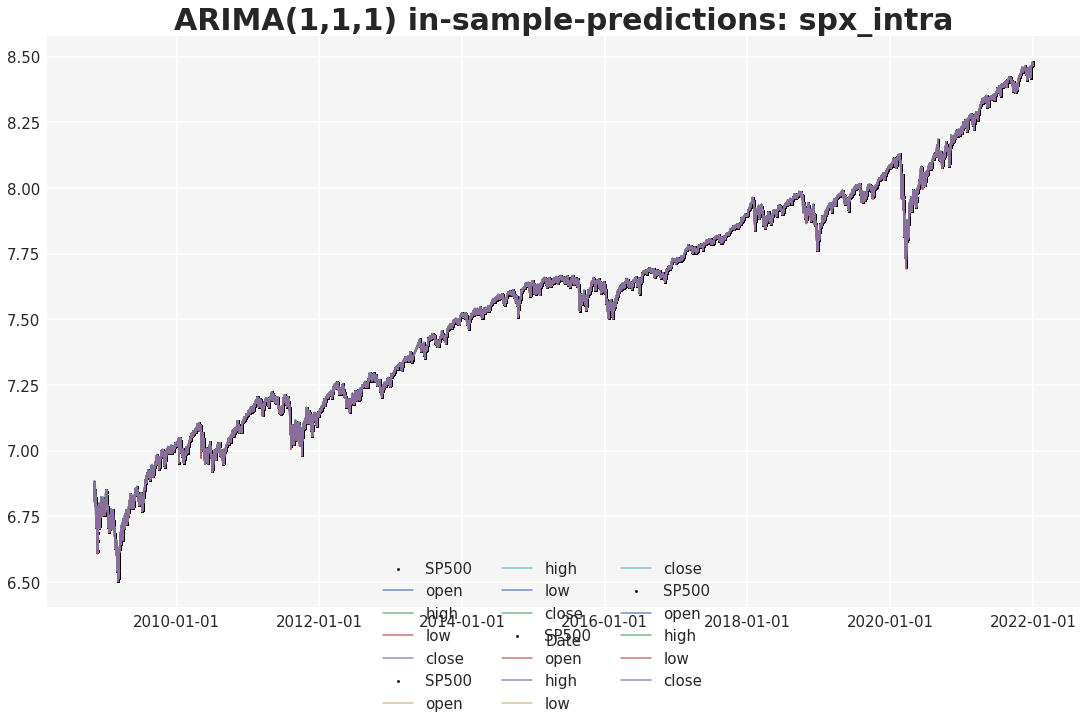

In [15]:
MIN_VAL = 1 + 3000
MAX_VAL = Y.shape[0] - 350
fig, ax = plt.subplots()
colours = ['red', 'orange', 'green', 'navy']
for i in range(dataset.shape[1]):
    ax.scatter(
        dataset.index.values[MIN_VAL:MAX_VAL],
        dataset['close'].values[MIN_VAL:MAX_VAL],
        marker = '.',
        s = SCATTER,
        alpha = 1,
        color = 'black',
        label = "SP500"
        )
    ax.plot(
        predicted.iloc[MIN_VAL:MAX_VAL],
        alpha = ALPHA,
        linewidth = LINEWIDTH,
        label = predicted.columns
        )

ax.set_facecolor('whitesmoke')
ax.xaxis.set_major_formatter(DATE_FORM)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel('Date',fontdict=AXIS_FONT)

fig.legend(loc=8, bbox_to_anchor=(0.5, -0.03), ncol=3, prop={'size':15})
# fig.autofmt_xdate()
fig.set_size_inches(18.5, 10.5)
plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
plt.title('ARIMA(1,1,1) in-sample-predictions: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
if show_plots:
    fig.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_arima_plots+'_ARIMA(1,1,1)_IN_SAMPLE_PRED_(close_up).png', dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')
# 

C:\Users\Keegan\AppData\Local\Temp\ipykernel_4100\2866498216.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


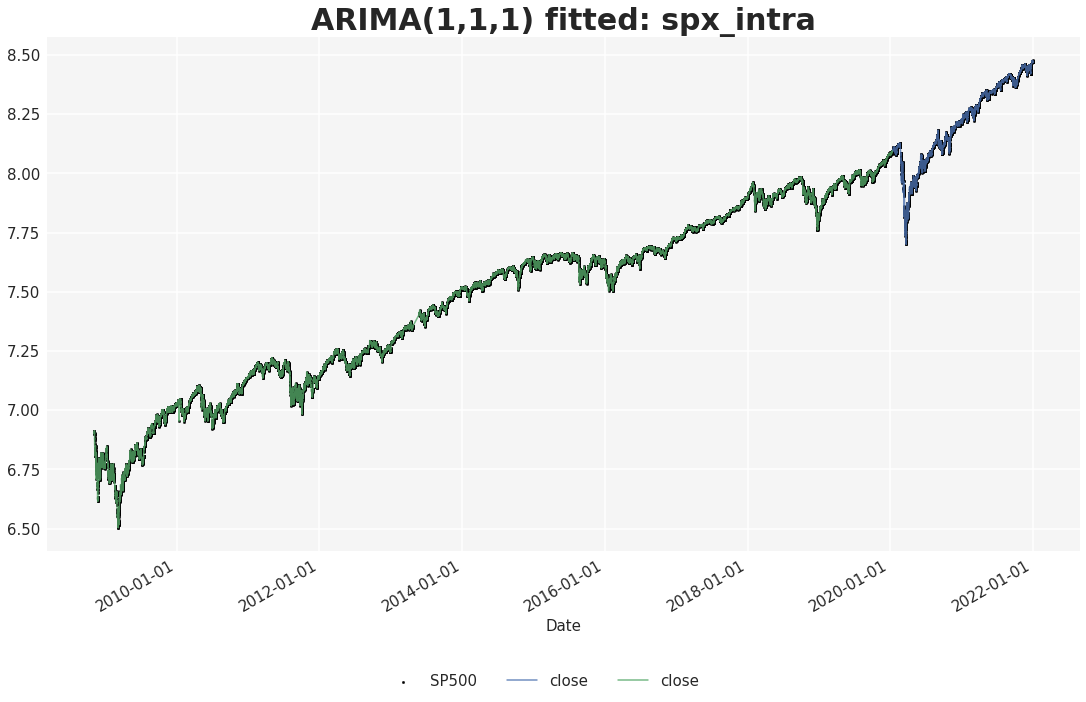

In [16]:
MIN_VAL = 1 + 2980
MAX_VAL = Y.shape[0] - 350
# Plot actual test vs. forecasts:
fig, ax = plt.subplots()
ax.scatter(
    dataset.index.values[MIN_VAL:MAX_VAL],
    dataset.close.values[MIN_VAL:MAX_VAL],
    marker = '.',
    s = SCATTER,
    alpha = 1,
    color = 'black',
    label = "SP500"
    )
ax.plot(
    predicted.close.iloc[dtrain.shape[0]:MAX_VAL],
    alpha = ALPHA,
    linewidth = LINEWIDTH,
    label = 'close' #predicted.columns
    )
ax.plot(
    predicted.close.iloc[MIN_VAL:dtrain.shape[0]],
    alpha = ALPHA,
    linewidth = LINEWIDTH,
    label = 'close' #predicted.columns
    )

ax.set_facecolor('whitesmoke')
ax.xaxis.set_major_formatter(DATE_FORM)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel('Date',fontdict=AXIS_FONT)

fig.legend(loc=8, ncol=4, prop={'size':15})
fig.autofmt_xdate()
fig.set_size_inches(18.5, 10.5)
plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
plt.title('ARIMA(1,1,1) fitted: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
if show_plots:
    fig.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_arima_plots+'_ARIMA(1,1,1)_full-fit_(close_up).png', dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

GARCH Modelling


In [17]:
# Specify forecast horizon
H = 10
garchs = {}
# Put ARIMA resids into dataframe to make life easier
for col in arima_resids.columns:
    # In-sample Model
    garch = ZeroMean(arima_resids[col][1:]*SCALE)
    garch.volatility = GARCH(p=ORDER[0],o=1,q=ORDER[2])
    garch.distribution = Normal(seed=1)
    garch_fit = garch.fit(last_obs = E1)
    # Out-sample Analytic Forecasts
    f = garch_fit.forecast(horizon = H, start=E1)

    # Conditional Volatilities
    # 1-period forward forecast conditional volatility
    fvol = pd.DataFrame({'date':f.variance['h.01'].index, 'cond_vol':f.variance['h.01'].pow(0.5)}).set_index('date')
    # sample estimated conditional volatility
    svol = pd.DataFrame({'date':garch_fit.conditional_volatility.index,'cond_vol':garch_fit.conditional_volatility}).set_index('date')
    # All conditional volatility from GARCH model
    cvol = pd.concat([svol.dropna(), fvol.dropna()])

    # Calculate Y_vol
    y_vol = pd.DataFrame(arima_resids[col][1:], copy=True).multiply(SCALE).pow(2).pow(0.5).rename({col:'y_vol'}, axis=1)

    # Calculate GARCH residuals
    garch_resids = pd.DataFrame({'date':y_vol.index, 'garch_resids':(y_vol.y_vol.values - cvol.cond_vol.values)}).set_index('date')
    
    # store model & results
    garchs[col] = {'forecast_model':f, 'fvol':fvol, 'svol':svol, 'cvol':cvol, 'y_vol':y_vol[1:], 'resid':garch_resids}

ps()

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08421. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -4158.838445845297
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4158.838293215146
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08105. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -4691.705804688146
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4691.705710923459
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09531. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: 69.97307460513048
Optimization terminated successfully    (Exit mode 0)
            Current function value: 69.97301631721871
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09536. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: 75.20177851485971
Optimization terminated successfully    (Exit mode 0)
            Current function value: 75.20198900701985
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


Select GARCH TS

In [18]:
keys = [*garchs.keys()]
cols = [*garchs[keys[0]].keys()]

for key in garchs.keys():
    f = garchs[key]['forecast_model']
    fvol = garchs[key]['fvol'][2:]
    svol = garchs[key]['svol'][2:]
    cvol = garchs[key]['cvol'][2:]
    y_vol = garchs[key]['y_vol'][1:]
    garch_resids = garchs[key]['resid'][1:]

GARCH Plots

C:\Users\Keegan\AppData\Local\Temp\ipykernel_4100\1886786593.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


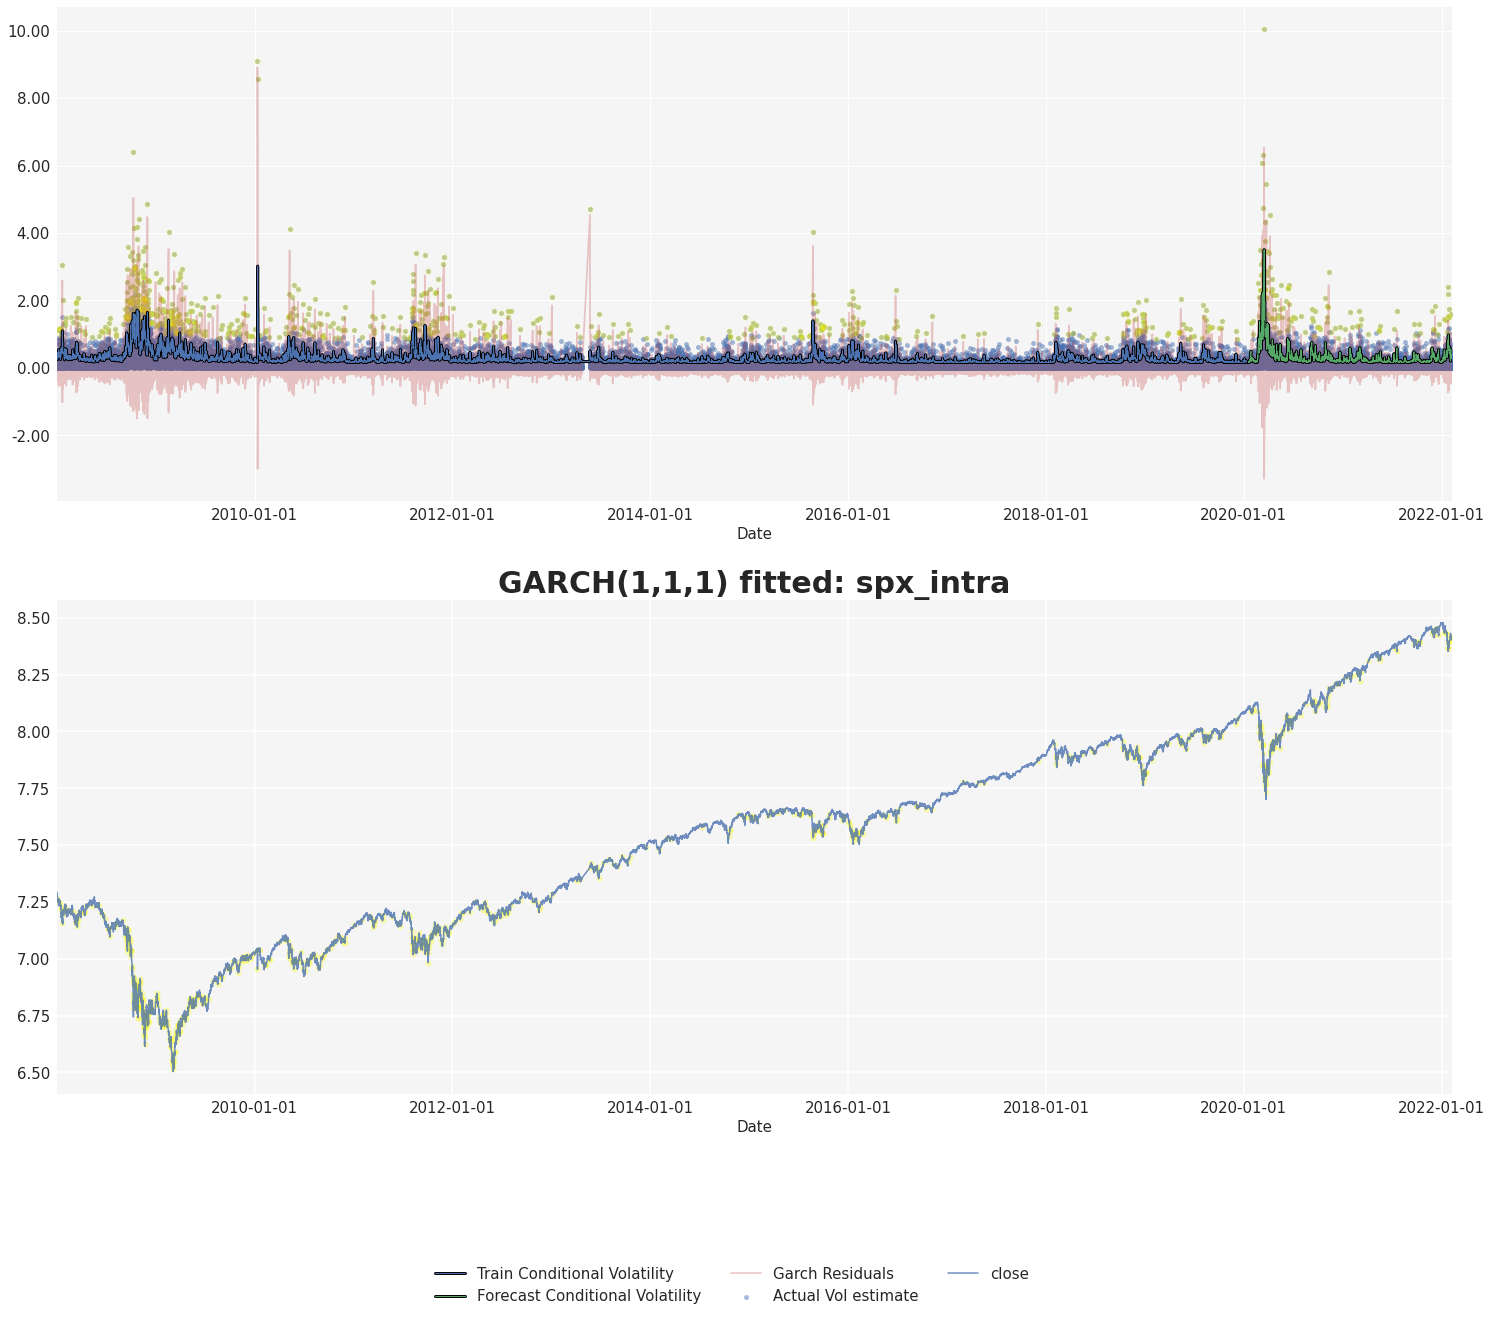

In [47]:
# Some formatting
PE = [pe.Stroke(linewidth=3, foreground='black'), pe.Normal()]
# Plot conditional volatilities
fig, ax = plt.subplots(2)

plt.title('GARCH(1,1,1) fitted: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
# ax.plot(garch_fit.conditional_volatility, color='black', label='Full-fit Conditional Volatility')
ax, ax2 = ax[0], ax[1]
# ax.plot(y_vol.rolling(window=200).mean(), label='MA(20)', linewidth=1, alpha=1, color='violet', zorder=0)

ax.plot(svol, label='Train Conditional Volatility', linewidth=1, path_effects = PE, zorder=10) #.divide(SCALE).pow(2)
ax.plot(fvol, label='Forecast Conditional Volatility', linewidth=1, path_effects = PE, zorder=9) #.divide(SCALE).pow(2)
ax.plot(garch_resids, label='Garch Residuals', alpha=0.3, zorder =2)

ax.scatter(x=y_vol.index, y=y_vol.values, label='Actual Vol estimate', s=20, alpha=0.5, zorder=1)
THRESHOLD = garch_resids.mean() + garch_resids.std()*3
flagged = y_vol.loc[garch_resids[garch_resids>=THRESHOLD].dropna().index]
ax.scatter(x=flagged.index, y=flagged, s=30, alpha=0.3, color='yellow')

# ax2.scatter()
flag_actual = dataset[key].loc[garch_resids[garch_resids>=THRESHOLD].dropna().index]
ax2.plot(dataset[key], alpha = ALPHA, linewidth = LINEWIDTH, label = key)
ax2.scatter(x=flag_actual.index, y=flag_actual.values, s=30, alpha=0.3, color='yellow')

ax.set_facecolor('whitesmoke')
ax2.set_facecolor('whitesmoke')
ax.margins(x=0)
ax2.margins(x=0)
ax.xaxis.set_major_formatter(DATE_FORM)
ax2.xaxis.set_major_formatter(DATE_FORM)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel('Date',fontdict=AXIS_FONT)
ax2.set_xlabel('Date',fontdict=AXIS_FONT)

fig.legend(loc=8, bbox_to_anchor=(0.5, -0.03), ncol=3, prop={'size':15})
# fig.autofmt_xdate()
fig.set_size_inches(25, 20)
plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)

if show_plots:
    fig.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_garch_plots+'GRJ-GARCH(1,1,1)_in-sample_vs_out-sample.png', dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

In [118]:
def equidate_ax(fig, ax, dates, fmt="%Y-%m-%d", label="Date"):
    """
    Sets all relevant parameters for an equidistant date-x-axis.
    Tick Locators are not affected (set automatically)

    Args:
        fig: pyplot.figure instance
        ax: pyplot.axis instance (target axis)
        dates: iterable of datetime.date or datetime.datetime instances
        fmt: Display format of dates
        label: x-axis label
    Returns:
        None

    """    
    N = len(dates)
    def format_date(index, pos):
        index = np.clip(int(index + 0.5), 0, N - 1)
        return dates[index].strftime(fmt)
    ax.xaxis.set_major_formatter(FuncFormatter(format_date))
    ax.set_xlabel(label)
    fig.autofmt_xdate()

C:\Users\Keegan\AppData\Local\Temp\ipykernel_4100\3537238601.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


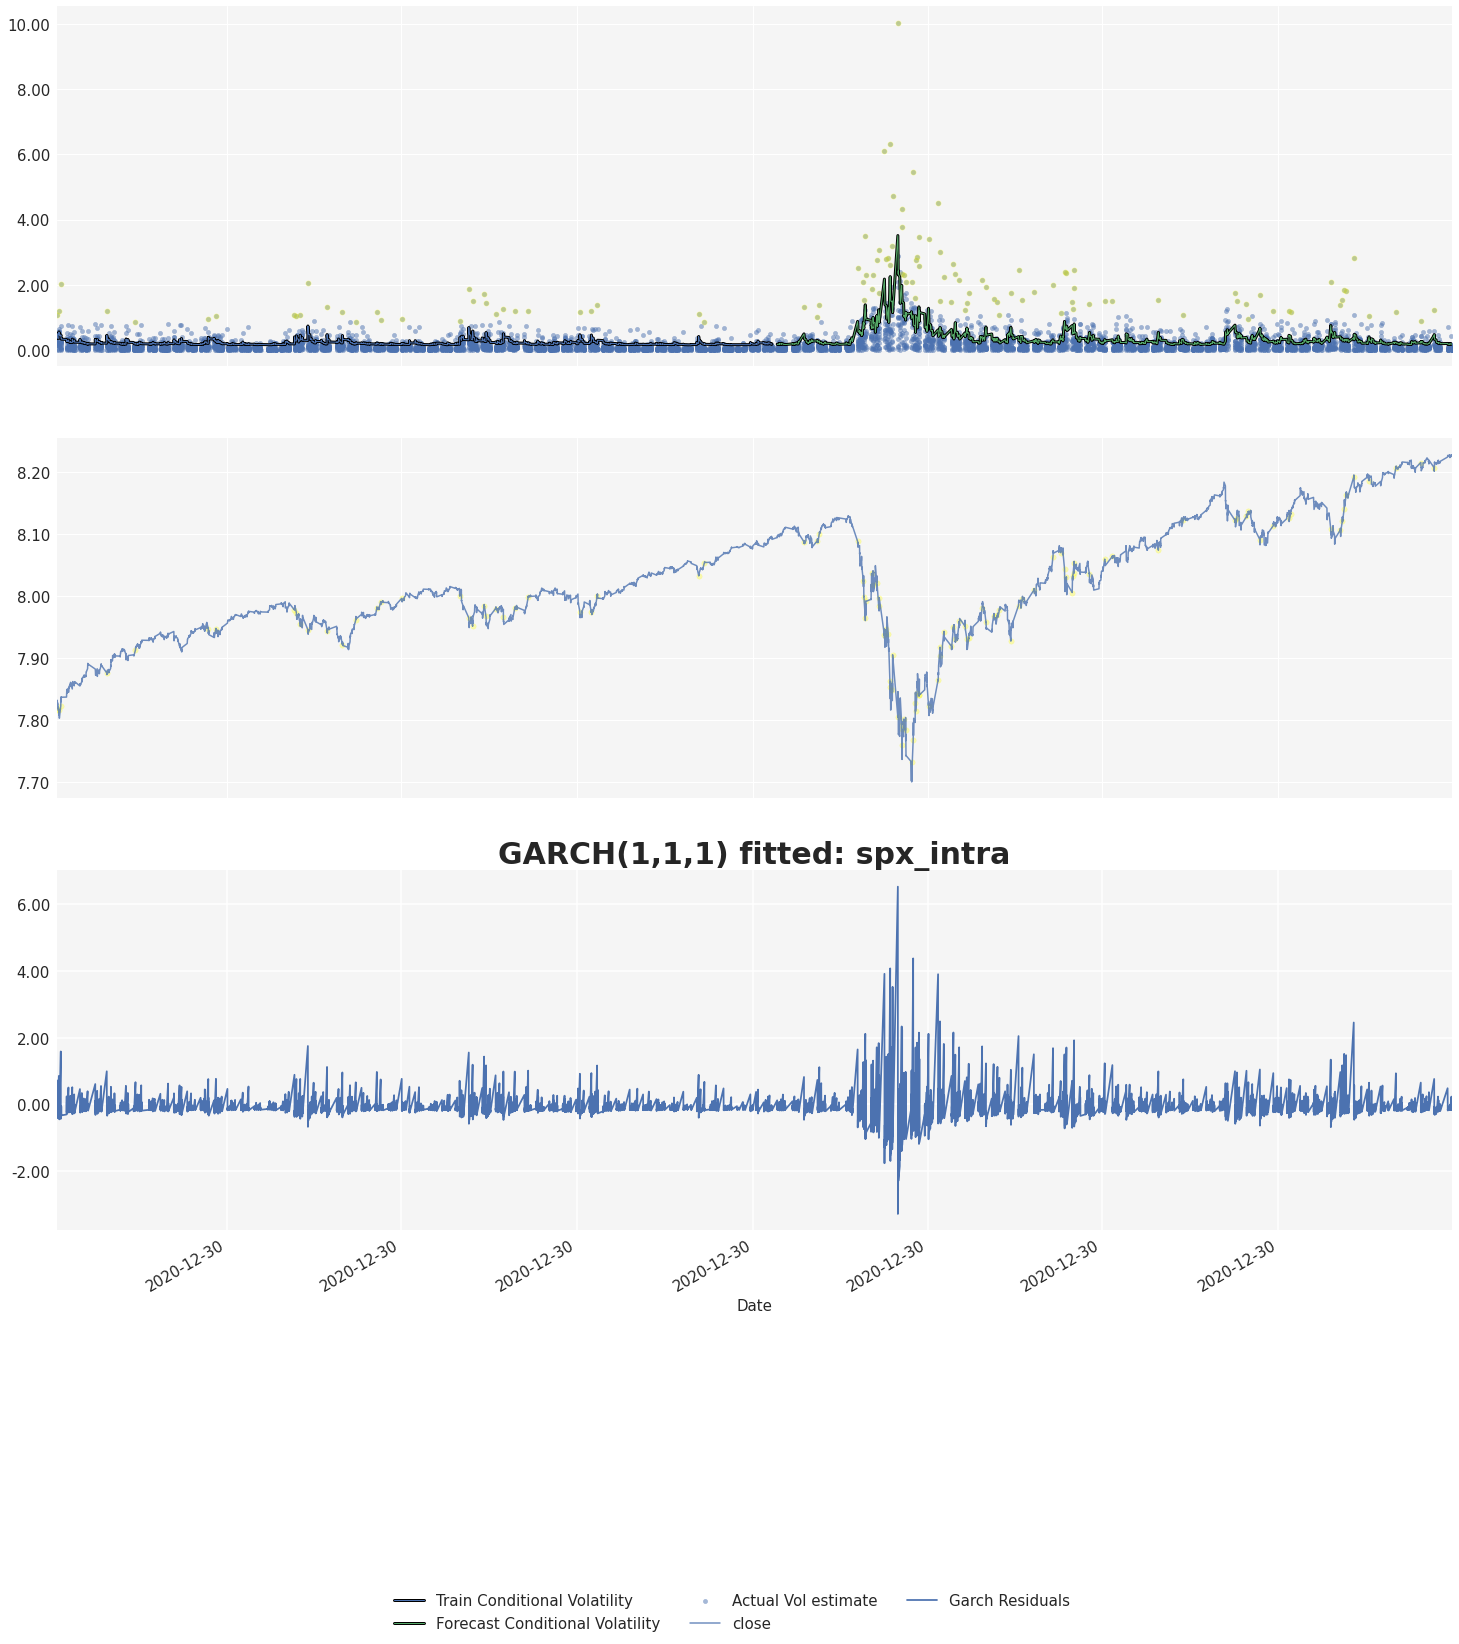

In [122]:
# Some formatting
PE = [pe.Stroke(linewidth=3, foreground='black'), pe.Normal()]
# Plot conditional volatilities
fig, axs = plt.subplots(3)
MIN_DATE = pd.to_datetime('2019-01-01')
MAX_DATE = pd.to_datetime('2020-12-31')

plt.title('GARCH(1,1,1) fitted: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
# ax.plot(garch_fit.conditional_volatility, color='black', label='Full-fit Conditional Volatility')
ax, ax2, ax3 = axs[0], axs[1], axs[2]
# ax.plot(y_vol.rolling(window=200).mean(), label='MA(20)', linewidth=1, alpha=1, color='violet', zorder=0)

ax.plot(svol[(svol.index>=MIN_DATE)&(svol.index<=MAX_DATE)], label='Train Conditional Volatility', linewidth=1, path_effects = PE, zorder=10) #.divide(SCALE).pow(2)
ax.plot(fvol[(fvol.index>=MIN_DATE)&(fvol.index<=MAX_DATE)], label='Forecast Conditional Volatility', linewidth=1, path_effects = PE, zorder=9) #.divide(SCALE).pow(2)

y_vol_plot = y_vol[(y_vol.index>=MIN_DATE)&(y_vol.index<=MAX_DATE)]
ax.scatter(x=y_vol_plot.index, y=y_vol_plot.values, label='Actual Vol estimate', s=20, alpha=0.5, zorder=1)
THRESHOLD = garch_resids.mean() + garch_resids.std()*3
flagged = y_vol.loc[garch_resids[(garch_resids>=THRESHOLD)].dropna().index]
flagged = flagged[(flagged.index >= MIN_DATE)&(flagged.index<=MAX_DATE)]
ax.scatter(x=flagged.index, y=flagged, s=30, alpha=0.3, color='yellow')

# ax2.scatter()
actual = dataset[key]
actual = actual[(actual.index >= MIN_DATE)&(actual.index<=MAX_DATE)]
flag_actual = dataset[key].loc[garch_resids[(garch_resids>=THRESHOLD)].dropna().index]
flag_actual = flag_actual[(flag_actual.index >= MIN_DATE)&(flag_actual.index<=MAX_DATE)]

ax2.plot(actual, alpha = ALPHA, linewidth = LINEWIDTH, label = key)
ax2.scatter(x=flag_actual.index, y=flag_actual.values, s=30, alpha=0.3, color='yellow')

ax3.plot(garch_resids[(garch_resids.index >= MIN_DATE)&(garch_resids.index<=MAX_DATE)], label='Garch Residuals', alpha=1, zorder =2)

ax.set_facecolor('whitesmoke')
ax2.set_facecolor('whitesmoke')
ax3.set_facecolor('whitesmoke')
ax.margins(x=0)
ax2.margins(x=0)
ax3.margins(x=0)
ax.xaxis.set_major_formatter(DATE_FORM)
ax2.xaxis.set_major_formatter(DATE_FORM)
ax3.xaxis.set_major_formatter(DATE_FORM)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel('Date',fontdict=AXIS_FONT)
ax2.set_xlabel('Date',fontdict=AXIS_FONT)
ax3.set_xlabel('Date',fontdict=AXIS_FONT)

equidate_ax(fig, ax, actual.index)
equidate_ax(fig, ax2, actual.index)
equidate_ax(fig, ax3, actual.index)


fig.legend(loc=8, bbox_to_anchor=(0.5, -0.03), ncol=3, prop={'size':15})
# fig.autofmt_xdate()
fig.set_size_inches(25, 25)
plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)

if show_plots:
    fig.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_garch_plots+'GRJ-GARCH(1,1,1)_in-sample_vs_out-sample.png', dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

In [21]:
# quiet = svol[svol.index>'2012-01-01']
# gfc = svol[svol.index<'2012-01-01']
# covid = fvol

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Keegan\AppData\Local\Temp\ipykernel_4100\584764101.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


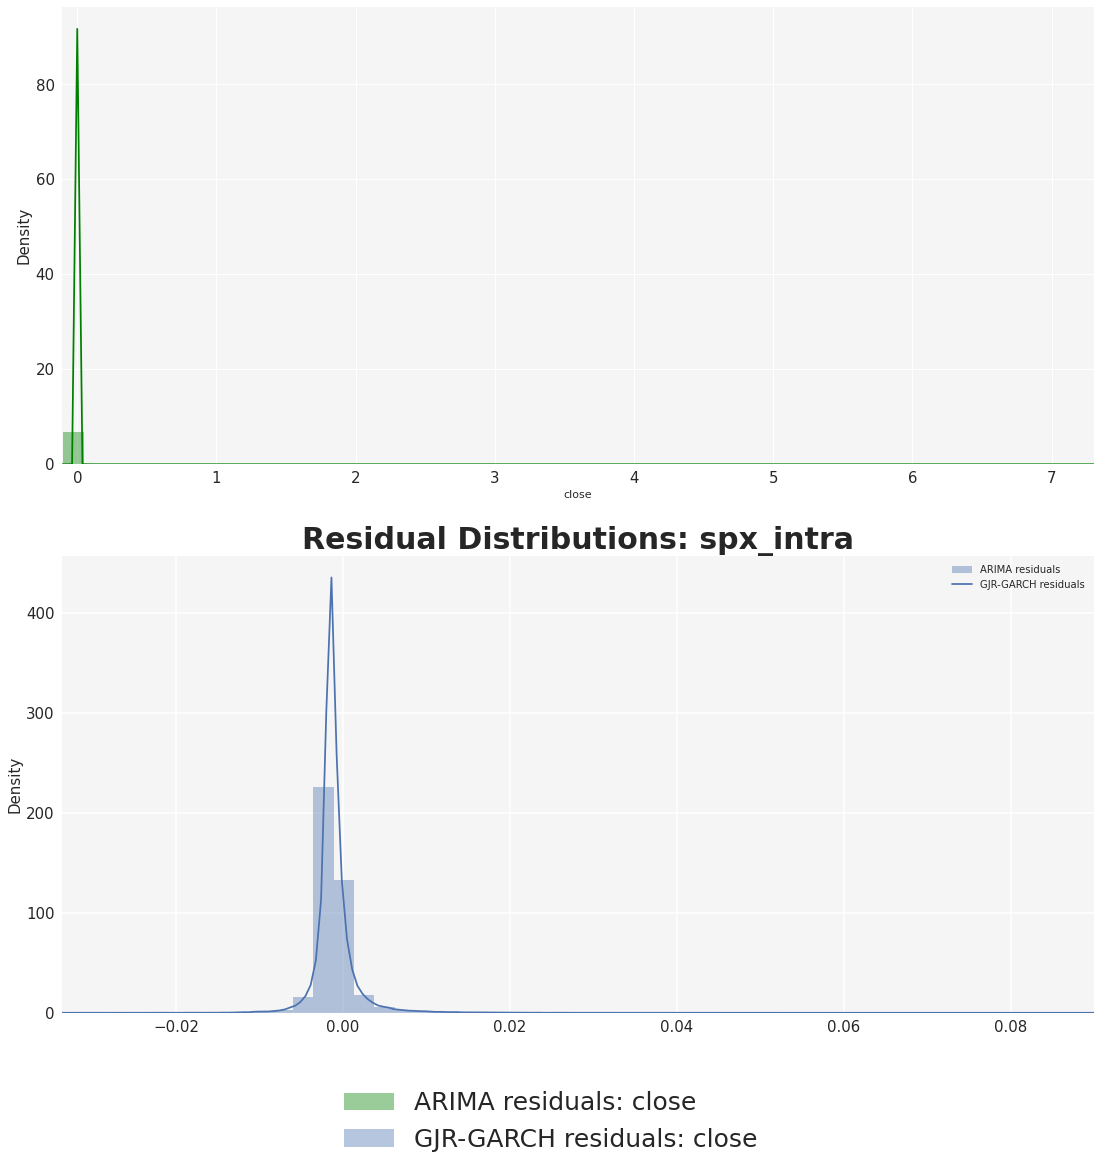

In [93]:
fig, axs = plt.subplots(2)

ax1 = axs[0]
ax2 = axs[1]

sns.distplot(arima_resids[key], ax=ax1, color='green', label='ARIMA residuals: '+key)
ax1.set_ylabel("Density", fontdict=AXIS_FONT)
ax1.set_facecolor('whitesmoke')
ax1.margins(x=0)

sns.distplot(garch_resids*DESCALE, ax=ax2, label='GJR-GARCH residuals: '+key)
ax2.set_ylabel("Density", fontdict=AXIS_FONT)
ax2.set_facecolor('whitesmoke')
ax2.margins(x=0)

plt.legend(labels=['ARIMA residuals','GJR-GARCH residuals'])

fig.legend(loc=8, ncol=1, prop={'size':25})
fig.set_size_inches(18.5, 18.5)
plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
plt.title('Residual Distributions: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
plt.legend(labels=['ARIMA residuals','GJR-GARCH residuals'])

if show_plots:
    fig.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_model_results+'ARIMA(1,1,1)_vs_GRJ-GARCH(1,1,1)_residual distributions.png', dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

STORAGE of Results

In [75]:
# RECORD GARCH RESULTS
# Residuals
if store_stats_results:
    garch_resids.to_csv(d_garch+MKT+'_GARCH'+str(ORDER)+'_residuals'+'.csv') 
else:
    print('Not storing'+' GJR-GARCH'+str(ORDER)+' residuals.')

# Extract and store garch model results
# Model characteristics
df_temp = pd.DataFrame(garch_fit.summary().tables[0])
# slice pieces out
tmp1 = df_temp.iloc[0:5,0:2]
tmp2 = df_temp.iloc[0:5,2:4]
tmp3 = df_temp.iloc[6:8,0:2]
tmp4 = df_temp.iloc[5:8,2:4]
# fix colnames
tmp1.columns = ['Item','Value']
tmp2.columns = ['Item','Value']
tmp3.columns = ['Item','Value']
tmp4.columns = ['Item','Value']
# merge and store
if store_stats_results:
    pd.concat([tmp1,tmp2,tmp3,tmp4]).set_index('Item').to_csv(d_garch+MKT+' GJR-GARCH'+str(ORDER)+'_characteristics'+'.csv')
    # cleanup
    del df_temp, tmp1, tmp2, tmp3, tmp4
else:
    print('Not storing'+' GJR-GARCH'+str(ORDER)+' characteristics.')
    # cleanup
    del df_temp, tmp1, tmp2, tmp3, tmp4

# Model parameters
df_temp = pd.DataFrame(garch_fit.summary().tables[1])
# restructure & store
df_temp.columns = df_temp.iloc[0]
tmp_cols = ['name']
[tmp_cols.append(str(n)) for n in list(df_temp.columns)[1:]]
df_temp.columns = tmp_cols

if store_stats_results:
    df_temp.drop(0).set_index('name').to_csv(d_garch+MKT+'_GJR-GARCH'+str(ORDER)+'_model_params'+'.csv')
    # cleanup
    del df_temp, tmp_cols
else:
    print('Not storing'+' GJR-GARCH'+str(ORDER)+' model params.')
    # cleanup
    del df_temp, tmp_cols

#####################
# RECORD ARIMA RESULTS
# Residuals
if store_stats_results:
    for col in predicted.columns:
        predicted[col].to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_residuals'+col+'.csv')
        arima_resids[col].to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_residuals'+col+'.csv')
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' residuals.')


# Extract and store garch model results
# Model characteristics
df_temp = pd.DataFrame(arimas[key]['model'].summary().tables[0])
nobs = int(str(df_temp.iloc[5,1]).replace(" ",""))
# slice unruly pieces out
tmp1 = df_temp[[0,1]]
tmp2 = df_temp[[2,3]].drop([5,6],axis=0).rename({2:0,3:1},axis=1)
# wrangle
df_temp = pd.concat([tmp1,tmp2])
df_temp.index = range(len(df_temp))
df_temp = df_temp.drop(5, axis=0)
df_temp.index = range(len(df_temp))
df_temp.iloc[4,1]=tuple([0, nobs])
df_temp.iloc[0:1,1:2] = MKT
df_temp = df_temp.rename({0:'Item',1:'Value'}, axis=1).set_index('Item')

if store_stats_results:
    df_temp.to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_characteristics'+'.csv')
    # cleanup
    del df_temp, tmp1, tmp2
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' characteristics.')
    # cleanup
    del df_temp, tmp1, tmp2

# ARIMA Model coefs & sigs
df_temp = pd.DataFrame(arimas[key]['model'].summary().tables[1])
# restructure & store
df_temp.columns = df_temp.iloc[0]
tmp_cols = ['name']
[tmp_cols.append(str(n)) for n in list(df_temp.columns)[1:]]
df_temp.columns = tmp_cols

if store_stats_results:
    df_temp.drop(0).set_index('name').to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_model_params'+'.csv')
    # cleanup
    del df_temp, tmp_cols
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' model params.')
    # cleanup
    del df_temp, tmp_cols

# ARIMA statistics
df_temp = pd.DataFrame(arimas[key]['model'].summary().tables[2])
tmp1 = df_temp[[0,1]]
tmp2 = df_temp[[2,3]].rename({2:0,3:1},axis=1)

if store_stats_results:
    pd.concat([tmp1,tmp2]).rename({0:'Statistic',1:'Value'}, axis=1).set_index('Statistic').to_csv(d_arima+MKT+'_ARIMA'+str(ORDER)+'_statistics'+'.csv')
    # cleanup
    del df_temp, tmp1, tmp2
else:
    print('Not storing'+' ARIMA'+str(ORDER)+' statistics.')
    # cleanup
    del df_temp, tmp1, tmp2
    
if store_stats_results:
    ps()
    print("Storage of ARIMA and GARCH models completed.")

.______________________________.

AE Prep & Settings

Funcs for data preprocessing

In [123]:
def bounded_scaler(vec, k=[-1,1], scale=True, MIN_MAX = None, SCALE_PARAMS = None):
    MAX = np.max(vec)
    MIN = np.min(vec)
    RANGE = MAX - MIN
    MULT = k[1] - k[0] # mult = b - a

    scale_params = {'min':MIN, 'max':MAX,'range':RANGE, 'b-a':MULT}
    if vec.ndim ==2:
        vec = vec.reshape(vec.shape[0])

    if scale:
        scaled_vec = np.subtract(np.multiply(np.divide(np.subtract(vec,MIN), RANGE), MULT), 1)
        return scaled_vec, scale_params
    elif MIN_MAX:
        if (isinstance(MIN_MAX,dict) == False):
            raise TypeError("MIN_MAX must be an object of dictionary class")
        else:
            RANGE = MIN_MAX['max'] - MIN_MAX['min']
            frac = np.divide(RANGE, MULT)
            unscaled_vec = np.add(np.multiply(np.subtract(vec, k[0]), frac), MIN_MAX['min'])
            del frac
            return unscaled_vec
    elif SCALE_PARAMS:
        if (isinstance(SCALE_PARAMS,dict) == False):
            raise TypeError("SCALE_PARAMS must be an object of dictionary class")
        else:
            frac = np.divide(SCALE_PARAMS['range'], MULT)
            unscaled_vec = np.add(np.multiply(np.subtract(vec, k[0]), frac), SCALE_PARAMS['min'])
            del frac
            return unscaled_vec
    else:
        raise ValueError("I don't know what you want me to do man. Check inputs.")


In [124]:
def lagged_df(vector, lags=LAGS, nans=False, scale=None):
    dct = OrderedDict()
    dct['date'] = vector.index.values #.reshape(len(train.index),1)
    if scale==None:
        for i in range(lags):
            if i ==0:
                dct['l'+str(i)] = vector.values.reshape(len(vector),)
            else:
                dct['l'+str(i)] = vector.shift(i).values.reshape(len(vector),)
    else:
        for i in range(lags):
            if i ==0:
                dct['l'+str(i)] = np.multiply(vector.values.reshape(len(vector),),scale)
            else:
                dct['l'+str(i)] = np.multiply(vector.shift(i).values.reshape(len(vector),),scale)
    if nans:
        df = pd.DataFrame(dct).set_index('date')
    else:
        df = pd.DataFrame(dct).set_index('date').dropna()

    return df

In [125]:
def create_sequences(values, time_steps=TIME_STEPS):
    # Generated training sequences for use in the model.
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(np.transpose(values[i : (i + time_steps)]))
    return np.stack(output)


ARIMA resid features

In [49]:
arima_resids_copy = arima_resids.copy(deep=True)

for col in arima_resids.columns:
    arima_resids = arima_resids_copy[col]

    # specify AE's train and test data
    if exclude:
        # Cuts out all data before and incl. the exclusion date
        train, test, full = arima_resids[(arima_resids.index > EXCLUSION) & (arima_resids.index < EVENT)], arima_resids[(arima_resids.index >= EVENT)], arima_resids
        train_dates, test_dates, full_dates = train.index, test.index, arima_resids.index
    else: 
        train, test, full = arima_resids[(arima_resids.index < EVENT)], arima_resids[(arima_resids.index >= EVENT)], arima_resids
        train_dates, test_dates, full_dates = train.index, test.index, arima_resids.index

    # unscale data
    # train, test, full = np.multiply(train, DESCALE), np.multiply(test, DESCALE), np.multiply(arima_resids, DESCALE)

    if rescale:
        # Rescale to be between [-1,1]
        train, test, full = bounded_scaler(train.values)[0], bounded_scaler(test.values)[0], bounded_scaler(full.values)[0]
        # convert to datetime indexed dataframes
        train, test = pd.DataFrame({'date':train_dates, 'data':train.reshape(len(train))}).set_index('date'), pd.DataFrame({'date':test_dates, 'data':test.reshape(len(test))}).set_index('date')
        full = pd.DataFrame({'date':full_dates, 'data':full.reshape(len(full))}).set_index('date')
    else:
        print('Not scaling according to bounds.')
    x_train, x_test, x_full = lagged_df(train, lags=LAGS), lagged_df(test, lags=LAGS), lagged_df(full, lags=LAGS)  #  scale=DESCALE 

    # Examine dims
    print('train shape',train.shape,'\n test shape:',test.shape,'\n long sum:',(train.shape[0]+test.shape[0],test.shape[1]),'\n full shape:',full.shape,'\n')
    print('x train shape: ', x_train.shape, '\n x test shape: ', x_test.shape, '\n x full shape: ', x_full.shape)
    x_train['l0'].describe()

Not scaling according to bounds.
train shape (34904, 1) 
 test shape: (7307, 1) 
 long sum: (42211, 1) 
 full shape: (49242, 1) 

x train shape:  (34777, 128) 
 x test shape:  (7180, 128) 
 x full shape:  (49115, 128)


count    34777.000000
mean         0.000011
std          0.002260
min         -0.038292
25%         -0.000808
50%          0.000046
75%          0.000880
max          0.055559
Name: l0, dtype: float64

In [37]:
# train = arima_resids[(arima_resids.index < EVENT)] 
# test = arima_resids[(arima_resids.index >= EVENT)]

# x_train = create_sequences(train.values)
# print("Training input shape: ", x_train.shape)

WandB Tracking & callbacks

In [38]:
# Tracking & callbacks
import wandb
from wandb.keras import WandbCallback

run = wandb.init(
    project='anomal',
    entity='keegangclarke',
    save_code=True,
    reinit=True,
    mode='online', # options are ['online', 'offline', 'disabled']
)
config = run.config

# length of data that will be used to create training dataset
config.train_data = 0.75
config.epochs = 1000
config.validation_split = 1 - config.train_data

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
GFLOPs,0.00084
best_epoch,26
best_val_loss,47.62813
epoch,29
loss,39.62709
val_loss,47.62813


AE Specification

In [50]:
RESIZE = 2 #TIME_STEPS/64*x_train.shape[1]
# model specification
LAYERS = [64*RESIZE, 46*RESIZE, 28*RESIZE, 10*RESIZE]
config.Lio, config.L2, config.L3, config.Lm  = LAYERS # config.L4, config.L5, config.L6, config.L7, config.L8,
config.act1, config.act2, config.actM, config.actF = ['tanh','tanh','tanh','tanh']
#learning params
config.batch =  256
config.initial = tf.keras.initializers.GlorotNormal()
LAYERS

[128, 92, 56, 20]

In [51]:
# Autoencoder
model = keras.Sequential(
    [   
        keras.layers.Flatten(input_shape=(x_train.shape[1],) #x_train.shape[2],
        ),
        keras.layers.Dense(
                    config.Lio, activation=config.act1,
        ),
        keras.layers.Dense(
                    config.L2, activation=config.act1,
        ),
        keras.layers.Dense(
                    config.L3, activation=config.act1,
        ),
        keras.layers.Dense(
                    config.Lm, activation=config.actM,
                    kernel_initializer='lecun_normal'
        ),
        keras.layers.Dense(
                    config.L3, activation=config.act2,
        ),
        keras.layers.Dense(
                    config.L2, activation=config.act2,
        ),
        keras.layers.Dense(
                    config.Lio, activation=config.actF,
        ),
        keras.layers.Reshape((x_train.shape[1],) #,x_train.shape[2]
        ),
    ]
)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 128)               16512     
                                                                 
 dense_29 (Dense)            (None, 92)                11868     
                                                                 
 dense_30 (Dense)            (None, 56)                5208      
                                                                 
 dense_31 (Dense)            (None, 20)                1140      
                                                                 
 dense_32 (Dense)            (None, 56)                1176      
                                                                 
 dense_33 (Dense)            (None, 92)               

Train AE

In [28]:
def round_seconds(obj: datetime) -> datetime:
    if obj.microsecond >= 500_000:
        obj += timedelta(seconds=1)
    return obj.replace(microsecond=0)

In [52]:
# give mode storage name which incl. meta data
MODEL = 'AE'+str(LAYERS)+'__'+str(pd.to_datetime(round_seconds(datetime.now()))).replace(':','_').replace(' ','__T_')
# fit model
history = model.fit(
    x=x_train, 
    y=x_train,
    batch_size=config.batch,
    epochs=config.epochs,
    validation_split=config.validation_split,
    shuffle=False,
    callbacks=[
        WandbCallback(),
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min'
            )
    ]
)
# play sound to notify cell is finished
ps()

Epoch 1/1000
 93/102 [==========================>...] - ETA: 0s - loss: 9.1063e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 4s 30ms/step - loss: 8.4396e-06 - val_loss: 4.7616e-06
Epoch 2/1000
 96/102 [===========================>..] - ETA: 0s - loss: 6.0632e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 2s 23ms/step - loss: 5.7921e-06 - val_loss: 4.3644e-06
Epoch 3/1000
 91/102 [=========================>....] - ETA: 0s - loss: 5.9007e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 2s 22ms/step - loss: 5.4330e-06 - val_loss: 4.1795e-06
Epoch 4/1000
 99/102 [============================>.] - ETA: 0s - loss: 5.3621e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 2s 23ms/step - loss: 5.2454e-06 - val_loss: 4.0654e-06
Epoch 5/1000
 94/102 [==========================>...] - ETA: 0s - loss: 5.4478e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 2s 23ms/step - loss: 5.1217e-06 - val_loss: 3.9833e-06
Epoch 6/1000
 92/102 [==========================>...] - ETA: 0s - loss: 5.4227e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 2s 23ms/step - loss: 5.0288e-06 - val_loss: 3.9202e-06
Epoch 7/1000
 92/102 [==========================>...] - ETA: 0s - loss: 5.3402e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 2s 25ms/step - loss: 4.9527e-06 - val_loss: 3.8662e-06
Epoch 8/1000
102/102 [==============================] - ETA: 0s - loss: 4.8881e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 3s 26ms/step - loss: 4.8881e-06 - val_loss: 3.8185e-06
Epoch 9/1000
 99/102 [============================>.] - ETA: 0s - loss: 4.9399e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 2s 24ms/step - loss: 4.8327e-06 - val_loss: 3.7772e-06
Epoch 10/1000
 90/102 [=========================>....] - ETA: 0s - loss: 5.2222e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 3s 27ms/step - loss: 4.7840e-06 - val_loss: 3.7436e-06
Epoch 11/1000
100/102 [============================>.] - ETA: 0s - loss: 4.8081e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 3s 28ms/step - loss: 4.7407e-06 - val_loss: 3.7124e-06
Epoch 12/1000
 97/102 [===========================>..] - ETA: 0s - loss: 4.8792e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 3s 29ms/step - loss: 4.7043e-06 - val_loss: 3.6877e-06
Epoch 13/1000
 91/102 [=========================>....] - ETA: 0s - loss: 5.0716e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 3s 27ms/step - loss: 4.6732e-06 - val_loss: 3.6682e-06
Epoch 14/1000
 98/102 [===========================>..] - ETA: 0s - loss: 4.7859e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 3s 33ms/step - loss: 4.6492e-06 - val_loss: 3.6518e-06
Epoch 15/1000
102/102 [==============================] - 1s 6ms/step - loss: 4.6322e-06 - val_loss: 3.6518e-06
Epoch 16/1000
 92/102 [==========================>...] - ETA: 0s - loss: 4.9758e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 3s 25ms/step - loss: 4.6161e-06 - val_loss: 3.6340e-06
Epoch 17/1000
 92/102 [==========================>...] - ETA: 0s - loss: 4.9648e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 3s 25ms/step - loss: 4.6060e-06 - val_loss: 3.6233e-06
Epoch 18/1000
102/102 [==============================] - 1s 5ms/step - loss: 4.5967e-06 - val_loss: 3.6283e-06
Epoch 19/1000
 91/102 [=========================>....] - ETA: 0s - loss: 4.9859e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 2s 21ms/step - loss: 4.5947e-06 - val_loss: 3.6124e-06
Epoch 20/1000
 98/102 [===========================>..] - ETA: 0s - loss: 4.7182e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 3s 25ms/step - loss: 4.5836e-06 - val_loss: 3.6093e-06
Epoch 21/1000
 96/102 [===========================>..] - ETA: 0s - loss: 4.7976e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 2s 22ms/step - loss: 4.5862e-06 - val_loss: 3.6081e-06
Epoch 22/1000
102/102 [==============================] - 0s 4ms/step - loss: 4.5737e-06 - val_loss: 3.6193e-06
Epoch 23/1000
 95/102 [==========================>...] - ETA: 0s - loss: 4.8428e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 3s 28ms/step - loss: 4.5913e-06 - val_loss: 3.6075e-06
Epoch 24/1000
 96/102 [===========================>..] - ETA: 0s - loss: 4.7771e-06INFO:tensorflow:Assets written to: c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best\assets


wandb: Adding directory to artifact (c:\Users\Keegan\anaconda3\envs\ml\dev_files\combined\wandb\run-20221130_181634-pls3rc4z\files\model-best)... Done. 0.0s


102/102 [==============================] - 3s 27ms/step - loss: 4.5669e-06 - val_loss: 3.6056e-06
Epoch 25/1000
102/102 [==============================] - 0s 4ms/step - loss: 4.5706e-06 - val_loss: 3.6168e-06
Epoch 26/1000
102/102 [==============================] - 0s 4ms/step - loss: 4.5617e-06 - val_loss: 3.6436e-06
Epoch 27/1000
102/102 [==============================] - 0s 4ms/step - loss: 4.5727e-06 - val_loss: 3.6119e-06
Epoch 28/1000
102/102 [==============================] - 0s 4ms/step - loss: 4.5655e-06 - val_loss: 3.6073e-06
Epoch 29/1000
102/102 [==============================] - 0s 4ms/step - loss: 4.5643e-06 - val_loss: 3.6283e-06
Epoch 30/1000
102/102 [==============================] - 0s 4ms/step - loss: 4.5625e-06 - val_loss: 3.6083e-06
Epoch 31/1000
102/102 [==============================] - 0s 4ms/step - loss: 4.5585e-06 - val_loss: 3.6132e-06
Epoch 32/1000
102/102 [==============================] - 0s 4ms/step - loss: 4.5626e-06 - val_loss: 3.6096e-06
Epoch 33/1000


AE Save

In [68]:
d_current_ae = d_ae_models+MODEL+'/'
Path(d_current_ae).mkdir(parents=True, exist_ok=True)

# save model
history.model.save(d_current_ae+MODEL+'.h5',save_format='h5')

# Get Model Summary as pd.DataFrame to store
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
summ_string = "\n".join(stringlist) # entire summary in a variable
table = stringlist[1:-4][1::2] # take every other element and remove appendix
new_table = []
for entry in table:
    entry = re.split(r'\s{2,}', entry)[:-1] # remove whitespace
    new_table.append(entry)

model_summary = pd.DataFrame(new_table[1:], columns=new_table[0]).to_csv(d_current_ae+MODEL+'_SUMMARY.csv')

# run.finish()

AE Predict

In [55]:
def unlag_df(df, nans=True):
    i = 0
    keys = df.columns
    for key in keys:
        df[key] = df[key].shift(-i)
        i += 1
    return df

In [56]:
# Get predictions
x_train_pred, x_test_pred, x_full_pred = history.model.predict(x_train), history.model.predict(x_test), history.model.predict(x_full)

print('train: ',x_train_pred.shape, '\n test: ', x_test_pred.shape)
lag_keys = ['l'+str(i) for i in range(LAGS)]

# Pandas.DataFrames for ease of use
train_pred = pd.DataFrame(x_train_pred, columns=lag_keys, index=x_train.index)
test_pred = pd.DataFrame(x_test_pred, columns=lag_keys, index=x_test.index)
full_pred = pd.DataFrame(x_full_pred, columns=lag_keys, index=x_full.index)

ewm_full_pred = full_pred.ewm(halflife=1/LAGS,axis=1).mean().sum(axis=1)

# LOSSES
# Absolute errors
train_mae = (train_pred - x_train).abs()#.mean(axis=1)
test_mae = (test_pred - x_test).abs()#.mean(axis=1)
full_mae = (full_pred - x_full).abs()#.mean(axis=1)

# MSE loss
# Crossectional 
train_mse_loss = (train_pred - x_train).pow(2).mean(axis=1)
test_mse_loss = (test_pred - x_test).pow(2).mean(axis=1)
full_mse_loss = (full_pred - x_full).pow(2).mean(axis=1)
# Per Feature
train_mse = (train_pred - x_train).pow(2).mean(axis=0)
test_mse = (test_pred - x_test).pow(2).mean(axis=0)
full_mse = (full_pred - x_full).pow(2).mean(axis=0)
# Unshifted Crossectional
reshifted_rmse_loss = unlag_df(full_pred - x_full).dropna().pow(2).mean(axis=1)
reshifted_mse_loss = unlag_df(full_pred - x_full).dropna().mean(axis=1)
# Unshifted Lags
unshifted_rmse = unlag_df(full_pred - x_full).dropna().pow(2).mean(axis=0)

# RMSE loss
# Crossectional
train_rmse_loss = train_mse_loss.pow(0.5)
test_rmse_loss = test_mse_loss.pow(0.5)
full_rmse_loss = full_mse_loss.pow(0.5)
# Per Feature
train_rmse = train_mse.pow(0.5)
test_rmse = test_mse.pow(0.5)
full_rmse = full_mse.pow(0.5)

# Get MAE loss
train_mae_loss = (train_pred - x_train).abs().mean(axis=1)
test_mae_loss = (test_pred - x_test).abs().mean(axis=1)
full_mae_loss = (full_pred - x_full).abs().mean(axis=1)


# prices = prices.set_index('date')

1535/1535 [==============================] - 1s 865us/step
train:  (34777, 128) 
 test:  (7180, 128)


AE Save predictions

In [69]:
if save_ae_results:
    # Create directories
    Path(d_current_ae+d_ae_predictions).mkdir(parents=True, exist_ok=True)
    Path(d_current_ae+d_ae_error).mkdir(parents=True, exist_ok=True)

    # Predictions
    train_pred.to_csv(path_or_buf=d_current_ae+d_ae_predictions+'TRAIN_PRED__'+MODEL+'.csv')
    test_pred.to_csv(d_current_ae+d_ae_predictions+'TEST_PRED__'+MODEL+'.csv')
    full_pred.to_csv(d_current_ae+d_ae_predictions+'FULL_PRED__'+MODEL+'.csv')

    # Error
    train_mse_loss.to_csv(d_current_ae+d_ae_error+'TRAIN_PRED_MSE__'+MODEL+'.csv')
    test_mse_loss.to_csv(d_current_ae+d_ae_error+'TEST_PRED_MSE__'+MODEL+'.csv')
    full_mse_loss.to_csv(d_current_ae+d_ae_error+'FULL_PRED_MSE__'+MODEL+'.csv')
    
    train_mae_loss.to_csv(d_current_ae+d_ae_error+'TRAIN_PRED_MAE__'+MODEL+'.csv')
    test_mae_loss.to_csv(d_current_ae+d_ae_error+'TEST_PRED_MAE__'+MODEL+'.csv')
    full_mae_loss.to_csv(d_current_ae+d_ae_error+'FULL_PRED_MAE__'+MODEL+'.csv')
    
else:
    print('Not saving model results')

AE Plots

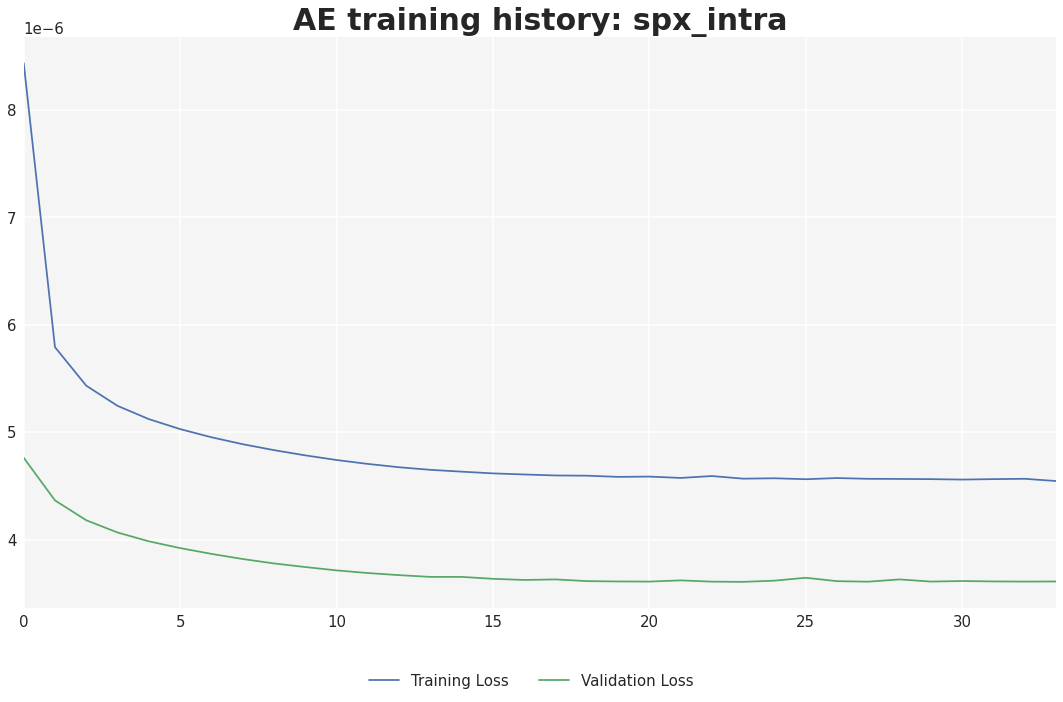

Not storing plot.


In [70]:
if show_plots:
    fig, ax = plt.subplots()

    ax.plot(history.history["loss"], label="Training Loss")
    ax.plot(history.history["val_loss"], label="Validation Loss")

    ax.set_facecolor('whitesmoke')
    ax.margins(x=0)
    fig.legend(loc=8, ncol=2, prop={'size':15})
    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)

    plt.title('AE training history: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_Training_history.png', dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

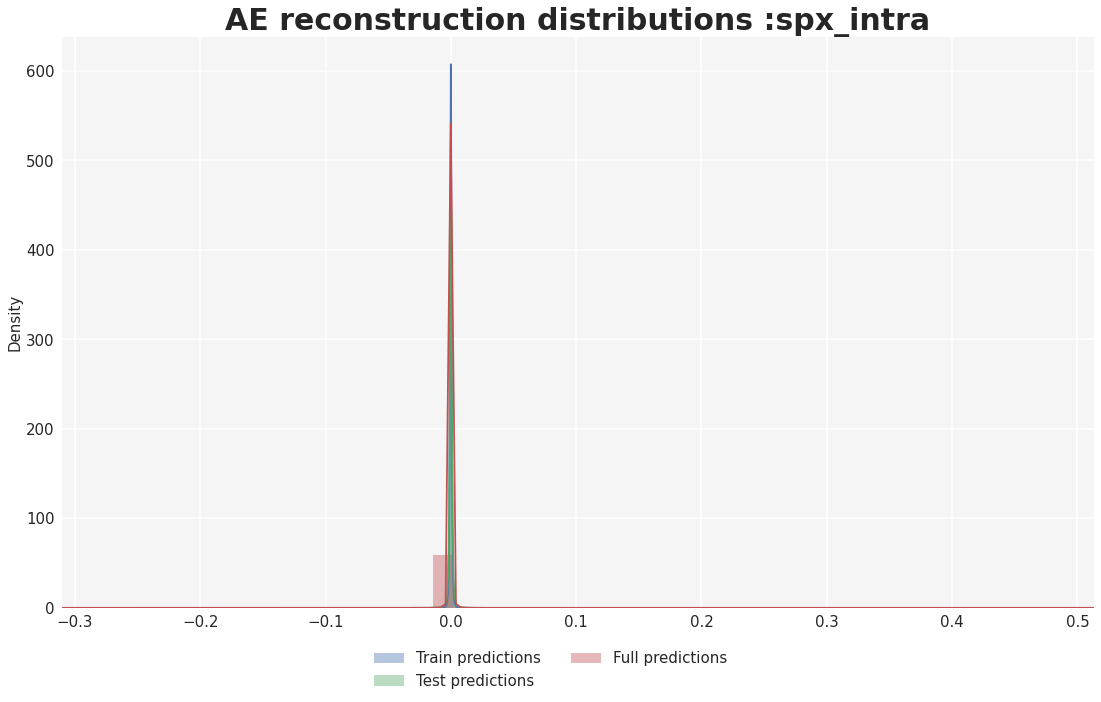

In [88]:
if show_plots:
    fig, ax = plt.subplots()

    sns.distplot(x_train_pred.reshape(x_train_pred.shape[1], x_train_pred.shape[0]), label='Train predictions')
    sns.distplot(x_test_pred.reshape(x_test_pred.shape[1], x_test_pred.shape[0]), label='Test predictions')
    sns.distplot(x_full_pred.reshape(x_full_pred.shape[1], x_full_pred.shape[0]), label='Full predictions')
    # sns.distplot(mean_full_pred, label='Mean predictions')

    ax.set_ylabel("Density", fontdict=AXIS_FONT)
    ax.set_facecolor('whitesmoke')
    ax.margins(x=0)

    fig.legend(loc=8, ncol=2, prop={'size':15})

    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.title('AE reconstruction distributions :'+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_reconstruction_distributions.png', dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


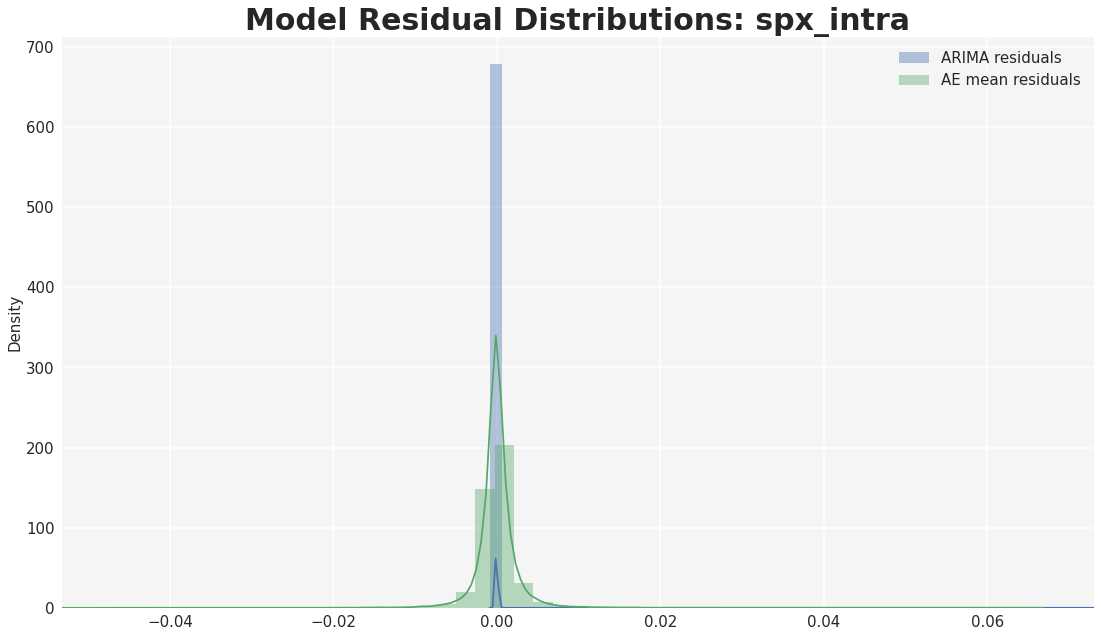

In [89]:
if show_plots:
    fig, ax = plt.subplots()
    
    sns.distplot(arima_resids*DESCALE, label='ARIMA residuals')
    # sns.distplot(garch_resids*DESCALE, label='GJR-GARCH residuals')
    sns.distplot(reshifted_mse_loss, label='AE mean residuals')

    ax.set_ylabel("Density", fontdict=AXIS_FONT)
    ax.set_facecolor('whitesmoke')
    ax.margins(x=0)

    # fig.legend()
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.88), ncol=1, prop={'size':15})
    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.title('Model Residual Distributions: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    # plt.legend(labels=['ARIMA residuals','GJR-GARCH residuals'])
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_model_results+'ARIMA(1,1,1)_vs_GRJ-GARCH(1,1,1)_vs_AE__residual_distributions.png', dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Keegan\AppData\Local\Temp\ipykernel_21316\3339361022.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


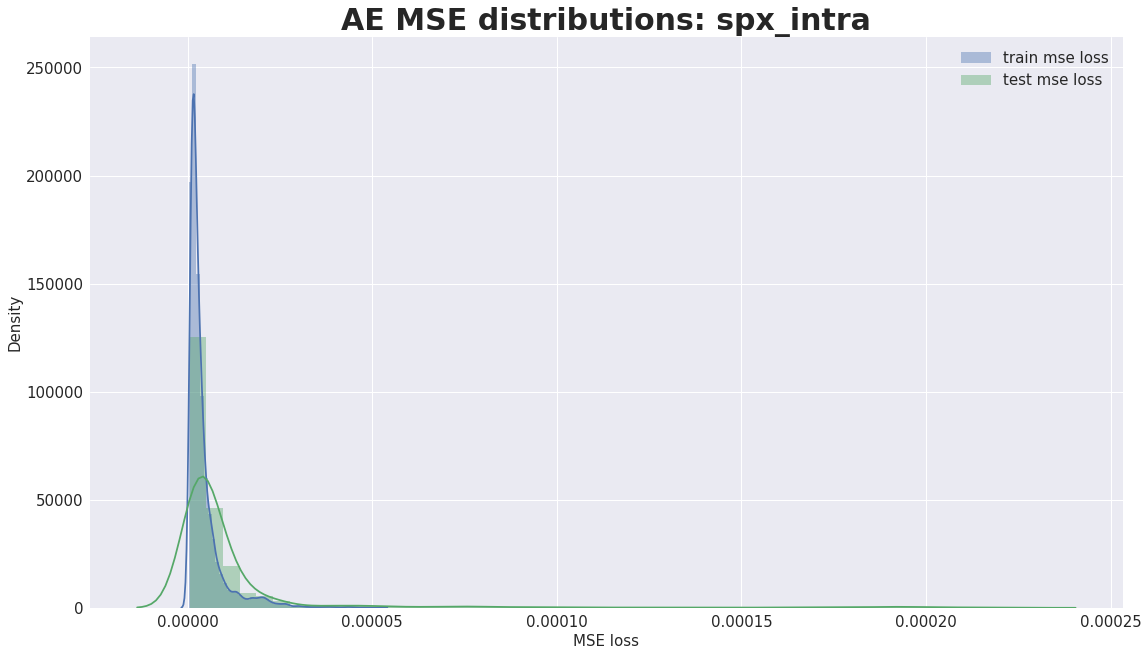

In [90]:
if show_plots:
    fig, ax = plt.subplots()

    sns.distplot(train_mse_loss, bins=50, label='train mse loss', ax=ax)
    sns.distplot(test_mse_loss, bins=50, label='test mse loss', ax=ax)
    # sns.distplot(full_mse_loss, bins=50, label='full mse loss', ax=ax)
    
    ax.set_xlabel("MSE loss", fontdict=AXIS_FONT)
    ax.set_ylabel("Density", fontdict=AXIS_FONT)
    
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.88),ncol=1, prop={'size':15})
    fig.set_size_inches(18.5, 10.5)
    plt.title('AE MSE distributions: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    fig.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'test_train_mse_loss_distributions.png', dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

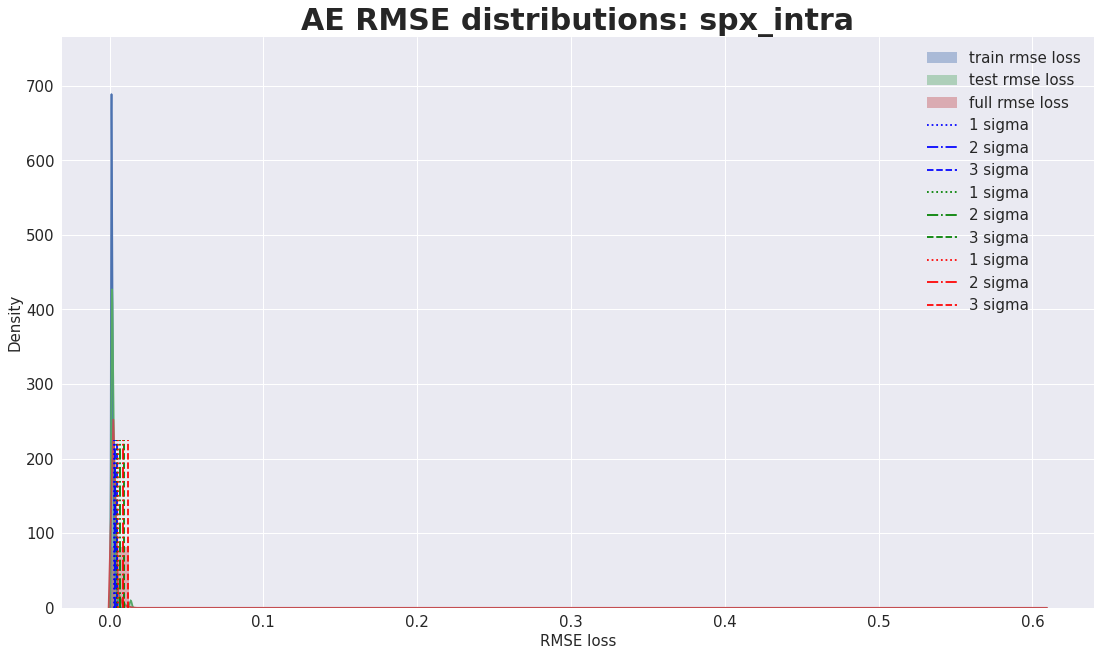

In [91]:
if show_plots:

    fig, ax = plt.subplots()

    sns.distplot(train_rmse_loss, bins=50, label='train rmse loss', ax=ax)
    sns.distplot(test_rmse_loss, bins=50, label='test rmse loss', ax=ax)
    sns.distplot(full_rmse_loss, bins=50, label='full rmse loss', ax=ax)

    ax.vlines(train_rmse_loss.mean() + train_rmse_loss.std(), ymin=0, ymax=225, color='blue', label='1 sigma', linestyle ='dotted')
    ax.vlines(train_rmse_loss.mean() +2*train_rmse_loss.std(), ymin=0, ymax=225, color='blue', label='2 sigma', linestyle ='dashdot')
    ax.vlines(train_rmse_loss.mean() +3*train_rmse_loss.std(), ymin=0, ymax=225, color='blue', label='3 sigma', linestyle ='--')

    ax.vlines(test_rmse_loss.mean() + test_rmse_loss.std(), ymin=0, ymax=225, color='green', label='1 sigma', linestyle ='dotted')
    ax.vlines(test_rmse_loss.mean() +2*test_rmse_loss.std(), ymin=0, ymax=225, color='green', label='2 sigma', linestyle ='dashdot')
    ax.vlines(test_rmse_loss.mean() +3*test_rmse_loss.std(), ymin=0, ymax=225, color='green', label='3 sigma', linestyle ='--')

    ax.vlines(full_rmse_loss.mean() + full_rmse_loss.std(), ymin=0, ymax=225, color='red', label='1 sigma', linestyle ='dotted')
    ax.vlines(full_rmse_loss.mean() +2*full_rmse_loss.std(), ymin=0, ymax=225, color='red', label='2 sigma', linestyle ='dashdot')
    ax.vlines(full_rmse_loss.mean() +3*full_rmse_loss.std(), ymin=0, ymax=225, color='red', label='3 sigma', linestyle ='--')

    # ax.vlines(train_rmse_loss.mean(), ymin=0, ymax=225, color='blue', label='mu (full)', linestyle ='-')
    # ax.vlines(train_rmse_loss.median(), ymin=0, ymax=225, color='black', label='mu (full)', linestyle ='-')
    # ax.vlines(test_rmse_loss.mean(), ymin=0, ymax=225, color='green', label='mu (full)', linestyle ='-')
    # ax.vlines(test_rmse_loss.median(), ymin=0, ymax=225, color='black', label='mu (full)', linestyle ='-')
    # ax.vlines(full_rmse_loss.mean(), ymin=0, ymax=225, color='red', label='mu (full)', linestyle ='-')
    # ax.vlines(full_rmse_loss.median(), ymin=0, ymax=225, color='black', label='mu (full)', linestyle ='-')

    ax.set_xlabel("RMSE loss", fontdict=AXIS_FONT)
    ax.set_ylabel("Density", fontdict=AXIS_FONT)
    
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.88),ncol=1, prop={'size':15})
    fig.set_size_inches(18.5, 10.5)
    plt.title('AE RMSE distributions: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    fig.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'mse_loss_distributions.png', dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Keegan\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

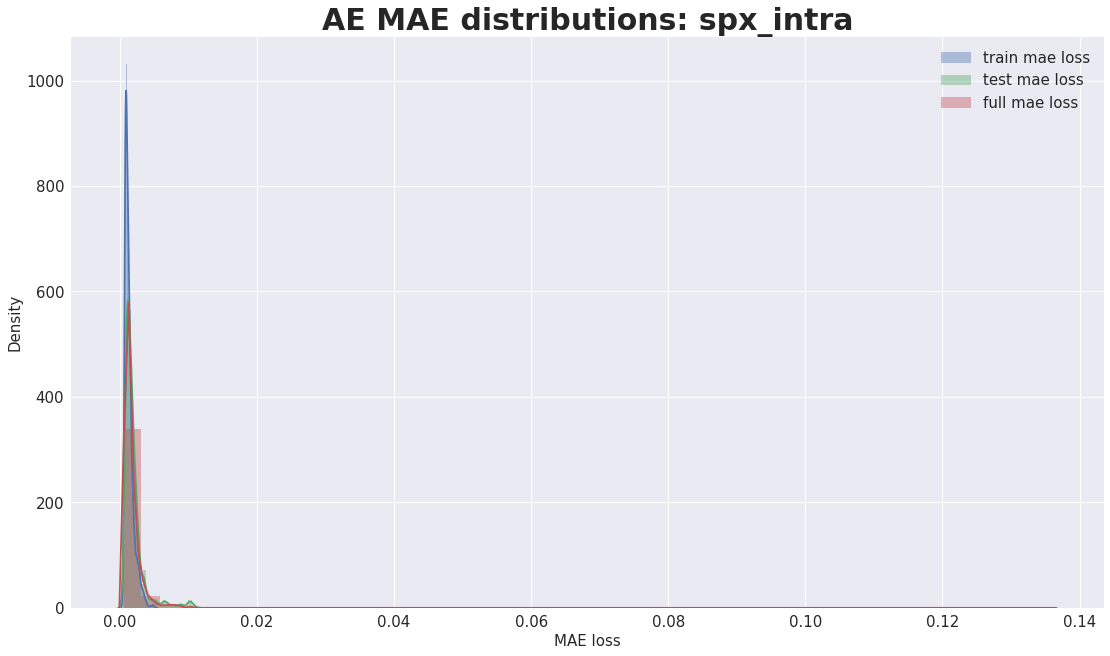

In [92]:
if show_plots:
    fig, ax = plt.subplots()
    
    sns.distplot(train_mae_loss, bins=50, label='train mae loss', ax=ax)
    sns.distplot(test_mae_loss, bins=50, label='test mae loss', ax=ax)
    sns.distplot(full_mae_loss, bins=50, label='full mae loss', ax=ax)
    ax.set_xlabel("MAE loss", fontdict=AXIS_FONT)
    ax.set_ylabel("Density", fontdict=AXIS_FONT)

    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.88),ncol=1, prop={'size':15})
    fig.set_size_inches(18.5, 10.5)
    plt.title('AE MAE distributions: '+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    fig.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'mae_loss_distributions.png', dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

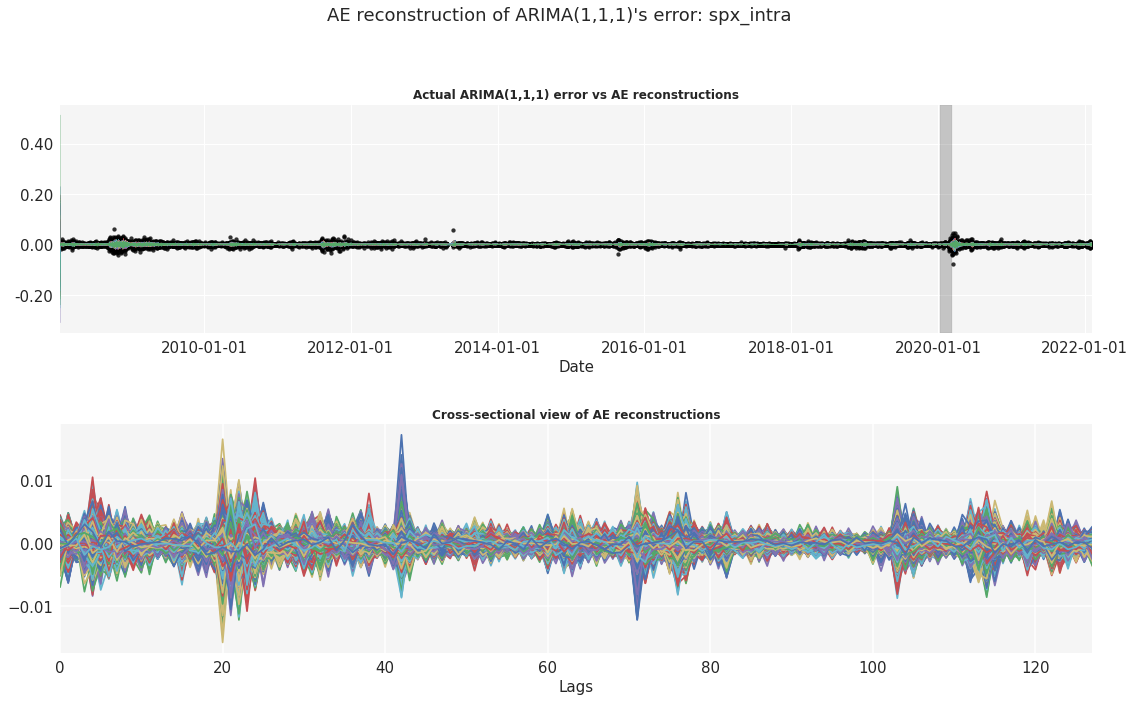

In [93]:
if show_plots:
    fig, axs = plt.subplots(2)

    ax1 = axs[0]
    ax2 = axs[1]
    # Insert Title
    fig.suptitle("AE reconstruction of ARIMA(1,1,1)'s error: "+str(MKT).replace('.',' '), fontdict=TITLE_FONT)
    fig.subplots_adjust(hspace=0.4, top=0.85)

    # Axis 1
    ax1.scatter(x_full['l0'].index,x_full['l0'], alpha=.8, s=15, color='black', label='Training data')
    for i in range(full_pred.shape[1]):
        ax1.plot(full_pred['l'+str(i)], linewidth=0.5) #, label = 'l'+str(i)
    # Vertical Shading
    ax1.axvspan(xmin=E1,xmax=E4, alpha=0.2, color='black')
    # Subtitle
    ax1.set_facecolor('whitesmoke')
    ax1.title.set_text('Actual ARIMA(1,1,1) error vs AE reconstructions')
    ax1.title.set_fontweight('semibold')
    # Settings
    ax1.margins(x=0)
    ax1.xaxis.set_major_formatter(DATE_FORM)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.set_xlabel('Date',fontdict=AXIS_FONT)

    # Axis 2
    ax2.plot(x_train_pred.reshape(x_train_pred.shape[1],x_train_pred.shape[0]))
    # Subtitle
    ax2.set_facecolor('whitesmoke')
    ax2.title.set_text('Cross-sectional view of AE reconstructions')
    ax2.title.set_fontweight('semibold')
    # Settings
    ax2.margins(x=0)
    ax2.set_xlabel('Lags', fontdict=AXIS_FONT)

    # Figure settings
    fig.set_size_inches(18.5, 10.5)
    
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_reconstruction_full-sample.png', dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

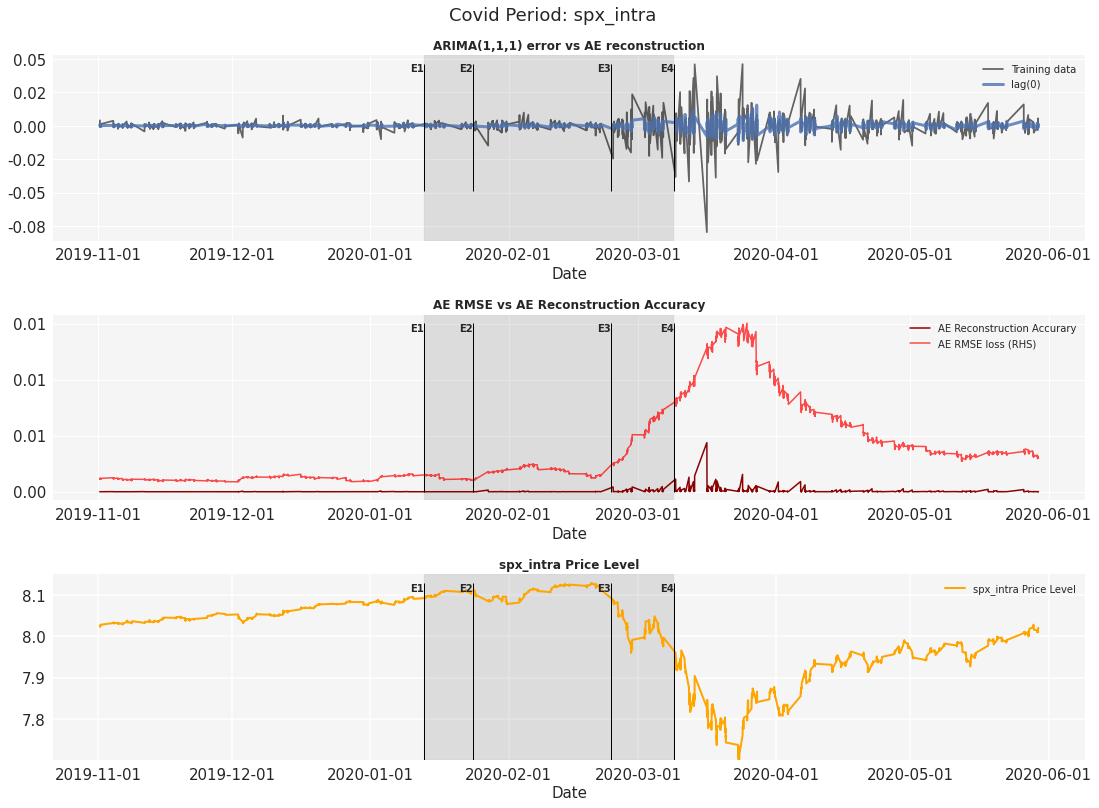

In [94]:
if show_plots:
    # determine slices to plot
    price_slice = prices[(prices.index>'2019-11-01')&(prices.index<'2020-06-01')]
    x_slice = x_full['l0'][(x_full.index>'2019-11-01')&(x_full.index<'2020-06-01')]
    full_slice = full_pred['l0'][(full_pred.index>'2019-11-01')&(full_pred.index<'2020-06-01')]
    reshifted_slice = reshifted_rmse_loss[(reshifted_rmse_loss.index>'2019-11-01')&(reshifted_rmse_loss.index<'2020-06-01')]
    rmse_slice = full_rmse_loss[(full_rmse_loss.index>'2019-11-01')&(full_rmse_loss.index<'2020-06-01')]
    # generate axes
    fig, axs = plt.subplots(3)
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    # Insert heading
    fig.suptitle('Covid Period: '+str(MKT).replace('.',' '), y = 0.9, fontdict=TITLE_FONT)    
    fig.subplots_adjust(hspace=0.4, top=0.85)

    # Axis 1
    ax1.plot(x_slice, alpha=.6, color='black', label='Training data')
    ax1.plot(full_slice, alpha=.8, label='lag(0)', linewidth=3)
    # Vertical lines
    ax1.vlines(E1, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)
    ax1.vlines(E2, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)
    ax1.vlines(E3, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)
    ax1.vlines(E4, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)

    ax1.text(E1, full_slice.max()*3, 'E1', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax1.text(E2, full_slice.max()*3, 'E2', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax1.text(E3, full_slice.max()*3, 'E3', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax1.text(E4, full_slice.max()*3, 'E4', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    # Settings
    # Subtitle
    ax1.set_facecolor('whitesmoke')
    ax1.title.set_text('ARIMA(1,1,1) error vs AE reconstruction')
    ax1.title.set_fontweight('semibold')
    ax1.axvspan(xmin=E1,xmax=E4, alpha=0.1, color='black')
    # X axis date formatting
    ax1.xaxis.set_major_formatter(DATE_FORM)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.set_xlabel('Date', fontdict=AXIS_FONT)
    ax1.legend()
    
    # Axis 2
    ax2.plot(reshifted_slice, color='darkred', label='AE Reconstruction Accurary', linewidth=1.5)
    ax2.plot(rmse_slice, alpha=0.7, color='red', label='AE RMSE loss (RHS)', linewidth=1.5)
    ax2.axvspan(xmin=E1,xmax=E4, alpha=0.1, color='black')
    # Vertical lines
    ax2.vlines(E1, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)
    ax2.vlines(E2, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)
    ax2.vlines(E3, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)
    ax2.vlines(E4, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)

    ax2.text(E1, rmse_slice.max(), 'E1', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax2.text(E2, rmse_slice.max(), 'E2', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax2.text(E3, rmse_slice.max(), 'E3', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax2.text(E4, rmse_slice.max(), 'E4', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    # Settings
    ax2.title.set_text('AE RMSE vs AE Reconstruction Accuracy')
    ax2.title.set_fontweight('semibold')
    ax2.set_facecolor('whitesmoke')
    ax2.xaxis.set_major_formatter(DATE_FORM)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_xlabel('Date', fontdict=AXIS_FONT)
    ax2.legend()

    # Axis 3
    ax3.plot(price_slice, color='orange', label=str(MKT).replace('.',' ')+' Price Level', linewidth=2)
    ax3.axvspan(xmin=E1,xmax=E4, alpha=0.1, color='black')
    # Vertical lines
    ax3.vlines(E1, ymin=price_slice.min(), ymax=price_slice.max(), color='black', linewidth=1)
    ax3.vlines(E2, ymin=price_slice.min(), ymax=price_slice.max(), color='black', linewidth=1)
    ax3.vlines(E3, ymin=price_slice.min(), ymax=price_slice.max(), color='black', linewidth=1)
    ax3.vlines(E4, ymin=price_slice.min(), ymax=price_slice.max(), color='black', linewidth=1)

    ax3.text(E1, price_slice.max(), 'E1', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax3.text(E2, price_slice.max(), 'E2', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax3.text(E3, price_slice.max(), 'E3', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax3.text(E4, price_slice.max(), 'E4', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    # Settings
    ax3.title.set_text(str(MKT).replace('.',' ')+' Price Level')
    ax3.title.set_fontweight('semibold')
    ax3.set_ylim(ymin=price_slice.min())
    ax3.set_facecolor('whitesmoke')
    ax3.xaxis.set_major_formatter(DATE_FORM)
    # ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax3.set_xlabel('Date', fontdict=AXIS_FONT)
    ax3.legend()

    # General Fig settings
    fig.set_size_inches(18.5, 13.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_covid-period__close-up.png',
                dpi=600, facecolor='white', edgecolor='white', bbox_inches='tight', pad_inches=0.1)
else:
    print('Not storing plot.')

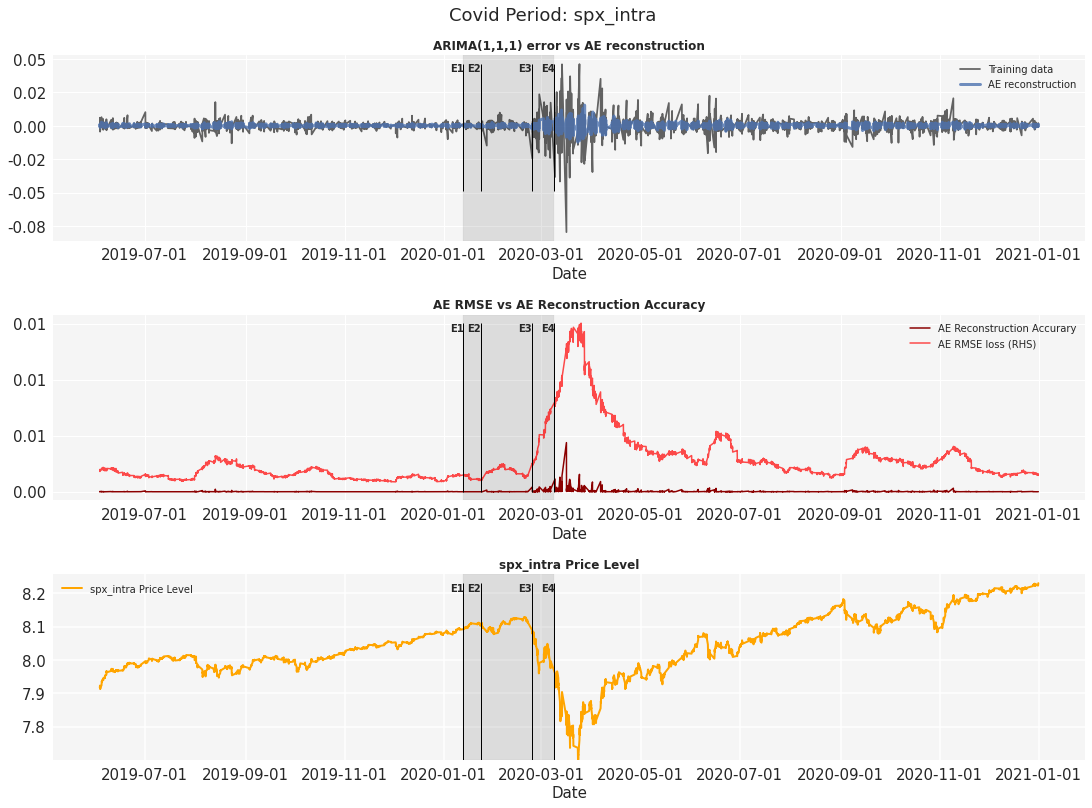

In [95]:
if show_plots:
    # determine slices to plot
    price_slice = prices[(prices.index>'2019-06-01')&(prices.index<'2021-01-01')]
    x_slice = x_full['l0'][(x_full.index>'2019-06-01')&(x_full.index<'2021-01-01')]
    full_slice = full_pred['l0'][(full_pred.index>'2019-06-01')&(full_pred.index<'2021-01-01')]
    reshifted_slice = reshifted_rmse_loss[(reshifted_rmse_loss.index>'2019-06-01')&(reshifted_rmse_loss.index<'2021-01-01')]
    rmse_slice = full_rmse_loss[(full_rmse_loss.index>'2019-06-01')&(full_rmse_loss.index<'2021-01-01')]
    # generate axes
    fig, axs = plt.subplots(3)
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    # Insert heading
    fig.suptitle('Covid Period: '+str(MKT).replace('.',' '), y = 0.9, fontdict=TITLE_FONT)    
    fig.subplots_adjust(hspace=0.4, top=0.85)

    # Axis 1
    ax1.plot(x_slice, alpha=.6, color='black', label='Training data')
    ax1.plot(full_slice, alpha=.8, label='AE reconstruction', linewidth=3)
    ax1.axvspan(xmin=E1,xmax=E4, alpha=0.1, color='black')
    # Vertical lines
    ax1.vlines(E1, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)
    ax1.vlines(E2, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)
    ax1.vlines(E3, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)
    ax1.vlines(E4, ymin=full_slice.min()*4, ymax=full_slice.max()*3, color='black', linewidth=1)

    ax1.text(E1, full_slice.max()*3, 'E1', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax1.text(E2, full_slice.max()*3, 'E2', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax1.text(E3, full_slice.max()*3, 'E3', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax1.text(E4, full_slice.max()*3, 'E4', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    # Settings
    # Subtitle
    ax1.set_facecolor('whitesmoke')
    ax1.title.set_text('ARIMA(1,1,1) error vs AE reconstruction')
    ax1.title.set_fontweight('semibold')
    # X axis date formatting
    ax1.xaxis.set_major_formatter(DATE_FORM)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.set_xlabel('Date', fontdict=AXIS_FONT)
    ax1.legend()
    
    # Axis 2
    ax2.plot(reshifted_slice, color='darkred', label='AE Reconstruction Accurary', linewidth=1.5)
    ax2.plot(rmse_slice, alpha=0.7, color='red', label='AE RMSE loss (RHS)', linewidth=1.5)
    ax2.axvspan(xmin=E1,xmax=E4, alpha=0.1, color='black')
    # Vertical lines
    ax2.vlines(E1, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)
    ax2.vlines(E2, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)
    ax2.vlines(E3, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)
    ax2.vlines(E4, ymin=reshifted_slice.min(), ymax=rmse_slice.max(), color='black', linewidth=1)

    ax2.text(E1, rmse_slice.max(), 'E1', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax2.text(E2, rmse_slice.max(), 'E2', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax2.text(E3, rmse_slice.max(), 'E3', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax2.text(E4, rmse_slice.max(), 'E4', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    # Settings
    ax2.title.set_text('AE RMSE vs AE Reconstruction Accuracy')
    ax2.title.set_fontweight('semibold')
    ax2.set_facecolor('whitesmoke')
    ax2.xaxis.set_major_formatter(DATE_FORM)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_xlabel('Date', fontdict=AXIS_FONT)
    ax2.legend()

    # Axis 3
    ax3.plot(price_slice, color='orange', label=str(MKT).replace('.',' ')+' Price Level', linewidth=2)
    ax3.axvspan(xmin=E1,xmax=E4, alpha=0.1, color='black')
    # Vertical lines
    ax3.vlines(E1, ymin=price_slice.min(), ymax=price_slice.max(), color='black', linewidth=1)
    ax3.vlines(E2, ymin=price_slice.min(), ymax=price_slice.max(), color='black', linewidth=1)
    ax3.vlines(E3, ymin=price_slice.min(), ymax=price_slice.max(), color='black', linewidth=1)
    ax3.vlines(E4, ymin=price_slice.min(), ymax=price_slice.max(), color='black', linewidth=1)

    ax3.text(E1, price_slice.max(), 'E1', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax3.text(E2, price_slice.max(), 'E2', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax3.text(E3, price_slice.max(), 'E3', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    ax3.text(E4, price_slice.max(), 'E4', horizontalalignment='right', verticalalignment='top', fontsize=10, fontweight='semibold')
    # Settings
    ax3.title.set_text(str(MKT).replace('.',' ')+' Price Level')
    ax3.title.set_fontweight('semibold')
    ax3.set_ylim(ymin=price_slice.min())
    ax3.set_facecolor('whitesmoke')
    ax3.xaxis.set_major_formatter(DATE_FORM)
    # ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax3.set_xlabel('Date', fontdict=AXIS_FONT)
    ax3.legend()

    # General Fig settings
    fig.set_size_inches(18.5, 13.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_covid-period.png',
                dpi=600, facecolor='white', edgecolor='white', bbox_inches='tight', pad_inches=0.1)
else:
    print('Not storing plot.')

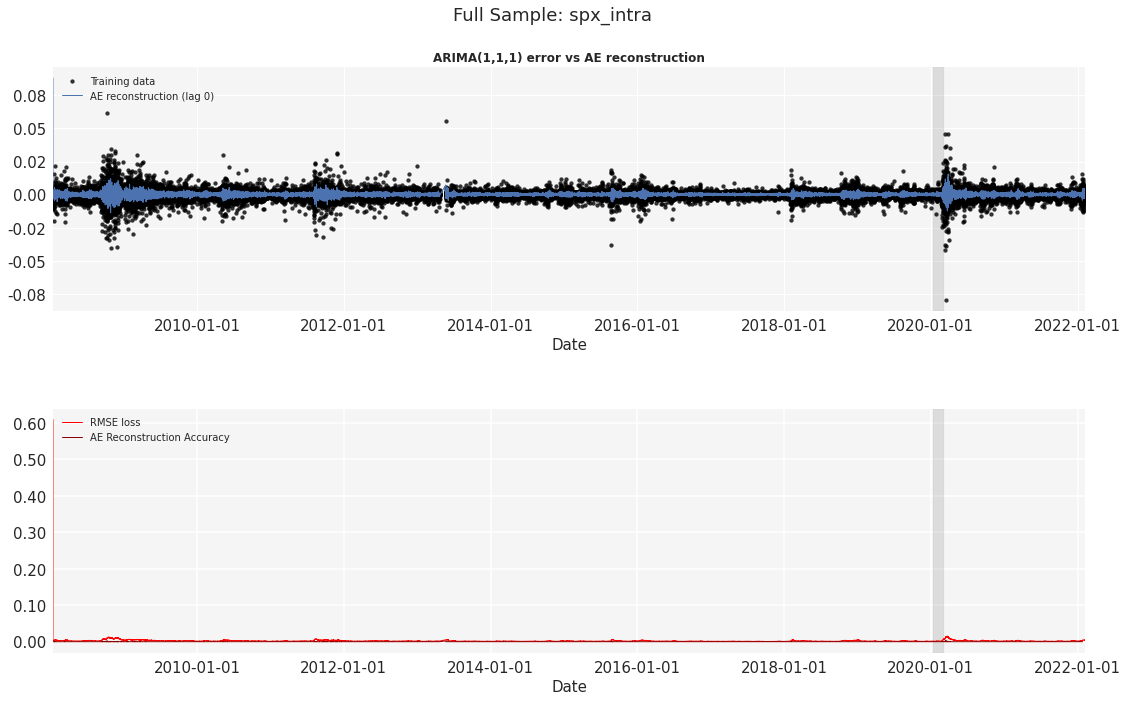

In [96]:
if show_plots:
    # Generate axes
    fig, axs = plt.subplots(2)
    ax1 = axs[0]
    ax2 = axs[1]
    # ax3 = axs[2]

    # Insert Title
    fig.suptitle('Full Sample: '+str(MKT).replace('.',' '), y = 0.98, fontdict=TITLE_FONT)
    fig.subplots_adjust(hspace=0.4, top=0.90)

    # Axis 1
    ax1.scatter(x_full['l0'].index, x_full['l0'], alpha=.8, s=15, color='black', label='Training data')
    ax1.plot(full_pred['l0'], linewidth=1, label='AE reconstruction (lag 0)')
    ax1.axvspan(xmin=E1,xmax=E4, alpha=0.1, color='black')
    # Settings
    ax1.set_facecolor('whitesmoke')
    ax1.margins(x=0)
    ax1.xaxis.set_major_formatter(DATE_FORM)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.set_xlabel('Date',fontdict=AXIS_FONT)
    ax1.title.set_text('ARIMA(1,1,1) error vs AE reconstruction')
    ax1.title.set_fontweight('semibold')
    ax1.legend()

    # Axis 2
    ax2.plot(full_rmse_loss, color='red', label='RMSE loss', linewidth=1)
    ax2.axvspan(xmin=E1,xmax=E4, alpha=0.1, color='black')
    ax2.plot(reshifted_rmse_loss, color='darkred', label='AE Reconstruction Accuracy', linewidth=1)
    # ax.plot(ewm_full_pred, linewidth=1.5)
    # Settings
    ax2.set_facecolor('whitesmoke')
    ax2.margins(x=0)
    ax2.xaxis.set_major_formatter(DATE_FORM)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_xlabel('Date',fontdict=AXIS_FONT)
    # ax2.title.set_text('RMSE Loss')
    # ax2.title.set_fontweight('semibold')
    ax2.legend()
    
    # Figure settings
    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_full-sample_preds.png', dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

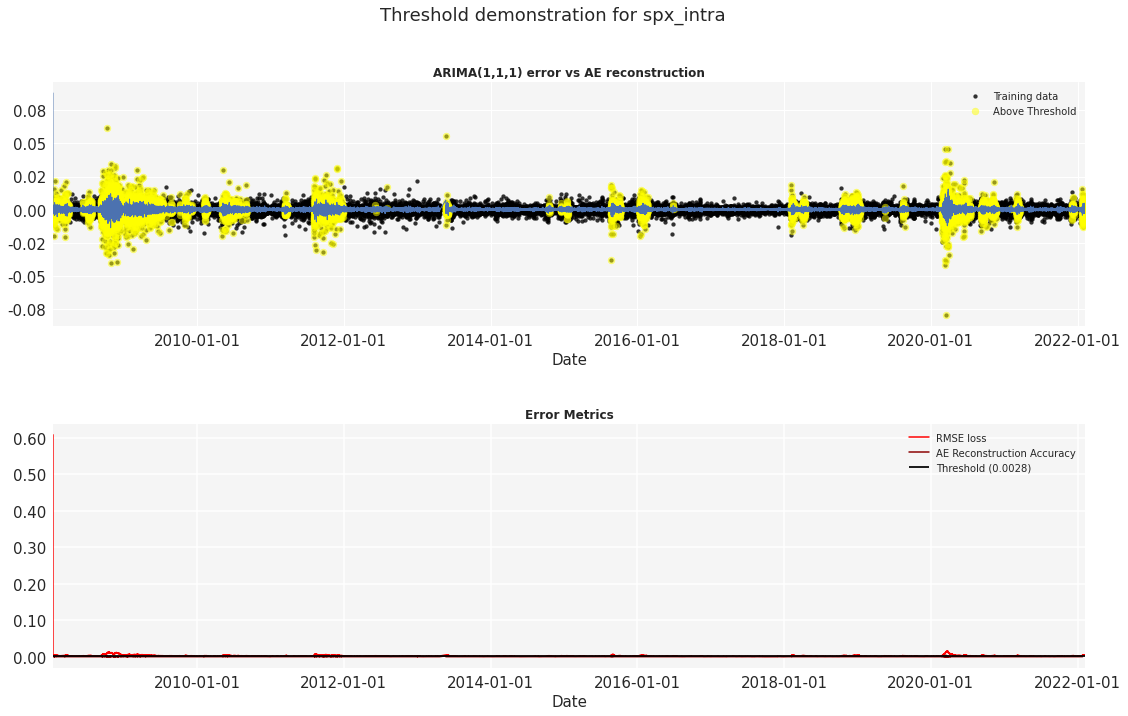

In [97]:
if show_plots:
    # Some formatting
    # PE = [pe.Stroke(linewidth=0.3, foreground='black'), pe.Normal()]
    THRESHOLD = train_rmse_loss.mean()+1*train_rmse_loss.std()
    # Generate Axes
    fig, axs = plt.subplots(2)
    ax1 = axs[0]
    ax2 = axs[1]
    # Insert Title
    fig.suptitle('Threshold demonstration for '+str(MKT).replace('.',' '), y=1, fontdict=TITLE_FONT)
    fig.subplots_adjust(hspace=0.4, top=0.9)

    # Axis 1
    ax1.scatter(x_full['l0'].index,x_full['l0'], alpha=.8, s=15, color='black', label='Training data')
    ax1.plot(full_pred['l0'], linewidth=1)
    ax1.scatter(x_full['l0'][full_rmse_loss>=THRESHOLD].index, x_full['l0'][full_rmse_loss>=THRESHOLD], s=50, alpha=0.5, color='yellow', label='Above Threshold')
    
    ax1.set_facecolor('whitesmoke')
    ax1.margins(x=0)
    ax1.xaxis.set_major_formatter(DATE_FORM)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.set_xlabel('Date',fontdict=AXIS_FONT)
    ax1.title.set_text('ARIMA(1,1,1) error vs AE reconstruction')
    ax1.title.set_fontweight('semibold')
    ax1.legend()

    # Axis 2
    ax2.plot(full_rmse_loss, color='red', label='RMSE loss', linewidth=1.5) #, path_effects = PE
    ax2.plot(reshifted_rmse_loss, color='darkred', label='AE Reconstruction Accuracy', linewidth=1.5)
    ax2.hlines(THRESHOLD, xmin=full_rmse_loss.index[0], xmax=full_rmse_loss.index[-1], color='black', label='Threshold ('+str(round(THRESHOLD, 4))+')')
    # ax2.scatter(full_rmse_loss[full_rmse_loss> THRESHOLD].index, full_rmse_loss[full_rmse_loss>THRESHOLD], s=50, alpha=0.5, color='yellow', label='Above RMSE Threshold: '+str(round(THRESHOLD, 4)))
    # ax.plot(ewm_full_pred, linewidth=1.5)

    ax2.set_facecolor('whitesmoke')
    ax2.margins(x=0)
    ax2.xaxis.set_major_formatter(DATE_FORM)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_xlabel('Date',fontdict=AXIS_FONT)
    ax2.title.set_text('Error Metrics')
    ax2.title.set_fontweight('semibold')
    ax2.legend()
    
    # fig.legend(loc=8, ncol=16, prop={'size':15})

    fig.set_size_inches(18.5, 10.5)
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.show()
else:
    print("Not showing plot.")
    
if show_plots & save_figs:
    fig.savefig(d_ae_plots+'AE_full-sample_threshold_demo.png',
    dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

Collective Plot

TypeError: 'float' object is not subscriptable

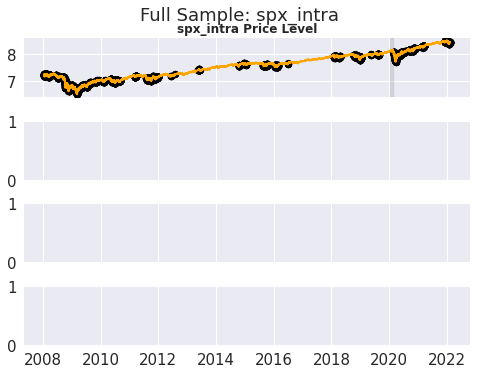

In [98]:
if show_plots:
    # Some formatting
    PE = [pe.Stroke(linewidth=3, foreground='black'), pe.Normal()]

    # Generate axes
    fig, axs = plt.subplots(4, sharex=True)
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    ax4 = axs[3]

    # Insert Title
    fig.suptitle('Full Sample: '+str(MKT).replace('.',' '), y = 0.98, fontdict=TITLE_FONT)
    fig.subplots_adjust(hspace=0.4, top=0.90)

    # Axis 1
    ax1.plot(prices[(prices.index>full_pred.index[0])], color='orange', label=str(MKT).replace('.',' ')+' Price Level', linewidth=2)
    ax1.scatter(prices.loc[full_rmse_loss.index[full_rmse_loss>=THRESHOLD]].index, prices.loc[full_rmse_loss.index[full_rmse_loss>=THRESHOLD]].values, color='black', alpha=1)
    ax1.axvspan(xmin=E1,xmax=E4, alpha=0.1, color='black')
    # Settings
    ax1.title.set_text(str(MKT).replace('.',' ')+' Price Level')
    ax1.title.set_fontweight('semibold')
    ax1.set_ylim(ymin=prices.min()[0])
    ax1.set_facecolor('whitesmoke')
    ax1.xaxis.set_major_formatter(DATE_FORM)
    # ax1.set_xlabel('Date', fontdict=AXIS_FONT)
    ax1.legend()

    # Axis 2
    ax2.scatter(x_full['l0'].index, x_full['l0'], alpha=.8, s=15, color='black', label='ARIMA(1,1,1) error')
    ax2.plot(full_pred['l0'], linewidth=1, label='AE reconstruction (lag 0)')
    ax2.scatter(x_full['l0'][full_rmse_loss>=THRESHOLD].index, x_full['l0'][full_rmse_loss>=THRESHOLD], s=50, alpha=0.5, color='yellow', label='Above Threshold')
    ax2.axvspan(xmin=E1,xmax=E4, alpha=0.1, color='black')
    # Settings
    ax2.set_facecolor('whitesmoke')
    ax2.margins(x=0)
    ax2.xaxis.set_major_formatter(DATE_FORM)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # ax2.set_xlabel('Date',fontdict=AXIS_FONT)
    ax2.title.set_text('ARIMA(1,1,1) error vs AE reconstruction')
    ax2.title.set_fontweight('semibold')
    ax2.legend()

    # Axis 3
    ax3.plot(full_rmse_loss, color='red', label='RMSE loss', linewidth=1)
    ax3.axvspan(xmin=E1,xmax=E4, alpha=0.1, color='black')
    ax3.plot(reshifted_rmse_loss, color='darkred', label='AE Reconstruction Accuracy', linewidth=1)
    ax3.hlines(THRESHOLD, xmin=full_rmse_loss.index[0], xmax=full_rmse_loss.index[-1], color='black', label='RMSE Threshold ('+str(round(THRESHOLD, 4))+')')    # Settings
    ax3.set_facecolor('whitesmoke')
    ax3.margins(x=0)
    ax3.xaxis.set_major_formatter(DATE_FORM)
    ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # ax3.set_xlabel('Date',fontdict=AXIS_FONT)
    ax3.title.set_text('AE Error metrics')
    ax3.title.set_fontweight('semibold')
    ax3.legend()

    # Axis 4
    ax4.plot(svol, label='Train Conditional Volatility', linewidth=2, zorder=10)
    ax4.plot(fvol, label='Forecast Conditional Volatility', linewidth=2, zorder=9)
    ax4.plot(garch_resids, label='Garch Residuals', alpha=0.3, zorder =2)
    ax4.axvspan(xmin=E1,xmax=E4, alpha=0.1, color='black')
    # Settings
    ax4.set_facecolor('whitesmoke')
    ax4.margins(x=0)
    ax4.xaxis.set_major_formatter(DATE_FORM)
    ax4.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax4.set_xlabel('Date',fontdict=AXIS_FONT)
    ax4.title.set_text('GJR-GARCH(1,1,1) Model')
    ax4.title.set_fontweight('semibold')
    ax4.legend()
    
    # Figure settings
    fig.set_size_inches(18.5, 20)
    fig.tight_layout()
    plt.grid(visible=True, which='both', axis='both', color='white', alpha=1, linewidth=1.5)
    plt.show()
    
if show_plots & save_figs:
    fig.savefig(d_model_results+'GRJ-GARCH(1,1,1)_in-sample_vs_out-sample.png', dpi=600, facecolor='white', edgecolor='white',bbox_inches = 'tight', pad_inches = 0.1)
else:
    print('Not storing plot.')

In [ ]:
ps()